In [1]:
import json
import torch
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import re
import os
from collections import defaultdict
import gc

In [2]:
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")

Device 0: NVIDIA H100 80GB HBM3
Device 1: NVIDIA H100 80GB HBM3
Device 2: NVIDIA H100 80GB HBM3
Device 3: NVIDIA H100 80GB HBM3


# Config

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create output directory
os.makedirs("interp_plots", exist_ok=True)

# Initialize model and tokenizer
MODEL_NAME = "meta-llama/Meta-Llama-3-8B-Instruct"
print("Loading model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,  # Use float16 to save memory
    device_map="auto"  # Automatically distribute across GPUs
)
model.eval()

# Get model config
num_layers = model.config.num_hidden_layers
print(f"Model has {num_layers} layers")

Using device: cuda
Loading model and tokenizer...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Model has 32 layers


In [4]:
def extract_correct_predictions(input_file, output_file, num_samples=200):
    """Extract prompts where pred == gold"""
    correct_prompts = []
    
    with open(input_file, 'r') as f:
        for line in f:
            data = json.loads(line)
            if data['pred'] == data['gold']:
                correct_prompts.append(data)
                if len(correct_prompts) >= num_samples:
                    break
    
    # Save to new file
    with open(output_file, 'w') as f:
        for prompt_data in correct_prompts:
            f.write(json.dumps(prompt_data) + '\n')
    
    print(f"Extracted {len(correct_prompts)} correct predictions")
    return correct_prompts

def parse_prompt(prompt):
    """Extract category type and list items from prompt"""
    type_match = re.search(r'Type: (\w+)', prompt)
    list_match = re.search(r'List: \[(.*?)\]', prompt)
    
    if not type_match or not list_match:
        raise ValueError("Could not parse prompt")
    
    category = type_match.group(1)
    items = [item.strip() for item in list_match.group(1).split(',')]
    
    return category, items

def get_token_positions_for_items(tokenizer, prompt, items):
    """Map each list item to its token position in the prompt"""
    # Tokenize the full prompt
    encoding = tokenizer(prompt, return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(encoding.input_ids[0])
    
    # Debug: print tokens for first example
    if items[0] == 'stool':  # First example
        print(f"\nDebug - Tokenization:")
        print(f"  Tokens (first 40): {tokens[:40]}")
        print(f"  Looking for items: {items}")
    
    # Find positions of list items
    item_positions = []
    
    for item in items:
        # Try to find the item in the token sequence
        item_lower = item.lower()
        found = False
        
        # Look for exact match first
        for i, token in enumerate(tokens):
            # Remove special tokens markers
            clean_token = token.replace('Ġ', '').replace('▁', '').lower()
            
            if clean_token == item_lower:
                item_positions.append(i)
                found = True
                break
        
        # If not found, look for partial matches (item might be split across tokens)
        if not found:
            # Tokenize the item separately
            item_tokens = tokenizer.tokenize(item)
            item_tokens_clean = [t.replace('Ġ', '').replace('▁', '').lower() for t in item_tokens]
            
            # Look for sequence of tokens
            for i in range(len(tokens) - len(item_tokens) + 1):
                tokens_slice = [tokens[j].replace('Ġ', '').replace('▁', '').lower() 
                               for j in range(i, i + len(item_tokens))]
                if tokens_slice == item_tokens_clean:
                    item_positions.append(i)
                    found = True
                    break
        
        # If still not found, append -1 as placeholder
        if not found:
            item_positions.append(-1)
    
    # Filter out -1 values
    valid_positions = [pos for pos in item_positions if pos != -1]
    
    if items[0] == 'stool':  # Debug first example
        print(f"  Found positions: {item_positions}")
        print(f"  Valid positions: {valid_positions}")
    
    return valid_positions

def is_category_match(item, category):
    """Check if an item belongs to a category"""
    CATEGORY_ITEMS = {
        "fruit": [
            "apple", "banana", "cherry", "grape", "orange",
            "pear", "peach", "mango", "tangerine", "plum"
        ],
        "animal": [
            "dog", "cat", "horse", "cow", "sheep",
            "lion", "tiger", "bear", "rabbit", "fox"
        ],
        "vehicle": [
            "car", "bus", "truck", "bicycle", "motorcycle",
            "train", "boat", "plane", "scooter", "van"
        ],
        "instrument": [           
            "guitar", "piano", "violin", "drum", "flute",
            "trumpet", "saxophone", "cello", "clarinet", "harp"
        ],
        "furniture": [            
            "chair", "table", "sofa", "bed", "desk",
            "cabinet", "dresser", "stool", "wardrobe", "bookshelf"
        ],
    }
    
    return item.lower() in CATEGORY_ITEMS.get(category.lower(), [])

def count_category_matches(items, category):
    """Count how many items match the category"""
    count = 0
    for item in items:
        if is_category_match(item, category):
            count += 1
    return count

def compute_running_counts(items, category):
    """Compute running count of category matches at each position"""
    running_counts = []
    count = 0
    for i, item in enumerate(items):
        if is_category_match(item, category):
            count += 1
        running_counts.append(count)
    return running_counts

def get_cumulative_counts_up_to_position(items, category, positions):
    """Get the cumulative count up to each token position"""
    # If we don't have valid positions, return empty
    if not positions:
        return []
    
    # For each token position, count how many category items we've seen
    cumulative_counts = []
    
    # Create a mapping of positions to items
    pos_to_item_idx = {}
    for item_idx, pos in enumerate(positions):
        if pos != -1 and item_idx < len(items):
            pos_to_item_idx[pos] = item_idx
    
    # Sort positions to process in order
    sorted_positions = sorted(positions)
    
    for pos in positions:  # Keep original order
        # Count items up to this position
        count = 0
        for sorted_pos in sorted_positions:
            if sorted_pos <= pos and sorted_pos in pos_to_item_idx:
                item_idx = pos_to_item_idx[sorted_pos]
                if item_idx < len(items) and is_category_match(items[item_idx], category):
                    count += 1
        cumulative_counts.append(count)
    
    return cumulative_counts

def get_hidden_states_with_hook(model, input_ids):
    """Get hidden states for all layers using hooks"""
    hidden_states = {}
    
    def hook_fn(name):
        def hook(module, input, output):
            # Store the hidden states, move to CPU immediately to save GPU memory
            hidden_states[name] = output[0].detach().cpu()
        return hook
    
    # Register hooks
    hooks = []
    for i in range(num_layers):
        layer = model.model.layers[i]
        hook = layer.register_forward_hook(hook_fn(f"layer_{i}"))
        hooks.append(hook)
    
    # Forward pass
    with torch.no_grad():
        with torch.cuda.amp.autocast():  # Use mixed precision to save memory
            outputs = model(input_ids)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    return hidden_states

def create_prefix_permuted_prompt(prompt, items, k):
    """Create a prompt with the first k+1 items shuffled"""
    # Shuffle first k+1 items
    prefix = items[:k+1].copy()
    random.shuffle(prefix)
    
    # Combine with rest of list
    permuted_items = prefix + items[k+1:]
    
    # Reconstruct prompt
    list_str = ', '.join(permuted_items)
    permuted_prompt = re.sub(r'List: \[.*?\]', f'List: [{list_str}]', prompt)
    
    return permuted_prompt, permuted_items

def train_probes(hidden_states_dict, running_counts_dict, token_positions_dict, layer_idx):
    """Train linear probes to predict running counts from hidden states"""
    X_all = []
    y_all = []
    
    for prompt_idx, hidden_states in hidden_states_dict.items():
        running_counts = running_counts_dict[prompt_idx]
        token_positions = token_positions_dict[prompt_idx]
        
        # Debug: print sample data
        if prompt_idx == 0 and layer_idx == 0:
            print(f"\nDebug - Prompt {prompt_idx}:")
            print(f"  Running counts: {running_counts}")
            print(f"  Token positions: {token_positions}")
            print(f"  Hidden states shape: {hidden_states.shape}")
        
        # For each list item and its corresponding token position
        for i, (count, token_pos) in enumerate(zip(running_counts, token_positions)):
            if token_pos < hidden_states.shape[1]:  # Ensure we're within bounds
                # Use the hidden state at this token position
                hidden_state = hidden_states[0, token_pos].numpy()
                X_all.append(hidden_state)
                y_all.append(count)
    
    if len(X_all) == 0:
        return None, 0.0
    
    X_all = np.array(X_all)
    y_all = np.array(y_all)
    
    # Debug: print training data info
    if layer_idx == 0:
        print(f"\nDebug - Training data for layer {layer_idx}:")
        print(f"  X shape: {X_all.shape}")
        print(f"  y shape: {y_all.shape}")
        print(f"  y unique values: {np.unique(y_all)}")
        print(f"  y mean: {np.mean(y_all):.3f}, std: {np.std(y_all):.3f}")
    
    # Split data for proper evaluation
    from sklearn.model_selection import train_test_split
    if len(X_all) > 20:  # Only split if we have enough data
        X_train, X_test, y_train, y_test = train_test_split(
            X_all, y_all, test_size=0.2, random_state=42
        )
    else:
        X_train, X_test = X_all, X_all
        y_train, y_test = y_all, y_all
    
    # Train Ridge regression with cross-validation
    from sklearn.model_selection import cross_val_score
    alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
    best_alpha = 1.0
    best_cv_score = -float('inf')
    
    for alpha in alphas:
        probe = Ridge(alpha=alpha)
        cv_scores = cross_val_score(probe, X_train, y_train, cv=3, scoring='r2')
        mean_cv_score = np.mean(cv_scores)
        if mean_cv_score > best_cv_score:
            best_cv_score = mean_cv_score
            best_alpha = alpha
    
    # Train final model with best alpha
    probe = Ridge(alpha=best_alpha)
    probe.fit(X_train, y_train)
    
    # Evaluate on test set
    y_pred = probe.predict(X_test)
    score = r2_score(y_test, y_pred)
    
    # Additional debug for first layer
    if layer_idx == 0:
        print(f"  Best alpha: {best_alpha}")
        print(f"  CV score: {best_cv_score:.4f}")
        print(f"  Test R² score: {score:.4f}")
    
    return probe, score

def patch_and_evaluate(model, tokenizer, prompt_data, layer_idx, probes):
    """Patch hidden states and evaluate impact on final answer"""
    prompt = prompt_data['prompt']
    gold_answer = prompt_data['gold']
    category, items = parse_prompt(prompt)
    
    # Get token positions for list items
    token_positions = get_token_positions_for_items(tokenizer, prompt, items)
    
    # Tokenize original prompt
    inputs = tokenizer(prompt, return_tensors="pt", padding=True).to(device)
    
    # Get clean run hidden states
    clean_hidden_states = get_hidden_states_with_hook(model, inputs.input_ids)
    
    patching_results = []
    
    for k in range(min(len(items) - 1, len(token_positions) - 1)):  # For each prefix position
        # Create prefix-permuted version
        permuted_prompt, permuted_items = create_prefix_permuted_prompt(prompt, items, k)
        permuted_count = count_category_matches(permuted_items, category)
        
        # Get counterfactual hidden states
        permuted_inputs = tokenizer(permuted_prompt, return_tensors="pt", padding=True).to(device)
        
        # Ensure both sequences have the same length
        if permuted_inputs.input_ids.shape[1] != inputs.input_ids.shape[1]:
            continue
            
        counterfactual_hidden_states = get_hidden_states_with_hook(model, permuted_inputs.input_ids)
        
        # Get the token position for item k
        if k >= len(token_positions):
            continue
        token_pos = token_positions[k]
        
        # Check if token position is valid
        if token_pos >= clean_hidden_states[f"layer_{layer_idx}"].shape[1]:
            continue
        
        # Patch at specified layer, token position for item k
        def patching_hook(module, input, output):
            # Replace hidden state at token position with counterfactual
            hidden_states = output[0]
            if token_pos < hidden_states.shape[1]:
                hidden_states[:, token_pos] = counterfactual_hidden_states[f"layer_{layer_idx}"][:, token_pos].to(device)
            return (hidden_states,) + output[1:]
        
        # Register patching hook
        hook = model.model.layers[layer_idx].register_forward_hook(patching_hook)
        
        # Run patched forward pass
        with torch.no_grad():
            outputs = model.generate(
                inputs.input_ids,
                max_new_tokens=10,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id,
                attention_mask=inputs.attention_mask
            )
        
        # Remove hook
        hook.remove()
        
        # Extract predicted number
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        pred_match = re.search(r'\((\d+)\)', generated_text)
        if pred_match:
            patched_pred = int(pred_match.group(1))
        else:
            patched_pred = -1
        
        patching_results.append({
            'position': k,
            'token_position': token_pos,
            'original_answer': gold_answer,
            'permuted_answer': permuted_count,
            'patched_prediction': patched_pred,
            'shifted_correctly': patched_pred == permuted_count
        })
    
    return patching_results

def visualize_probe_scores(probe_scores, best_layer):
    """Visualize probe R² scores across layers"""
    plt.figure(figsize=(12, 6))
    
    layers = sorted(probe_scores.keys())
    scores = [probe_scores[l] for l in layers]
    
    # Create bar plot
    bars = plt.bar(layers, scores, color='skyblue', edgecolor='navy', alpha=0.7)
    
    # Highlight best layer
    bars[best_layer].set_color('red')
    bars[best_layer].set_alpha(1.0)
    
    plt.xlabel('Layer', fontsize=12)
    plt.ylabel('R² Score', fontsize=12)
    plt.title('Linear Probe Performance Across Layers (Predicting Running Count)', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (layer, score) in enumerate(zip(layers, scores)):
        if layer == best_layer:
            plt.text(layer, score + 0.01, f'{score:.3f}', ha='center', fontweight='bold')
        elif i % 4 == 0:  # Show every 4th layer to avoid crowding
            plt.text(layer, score + 0.01, f'{score:.3f}', ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('interp_plots/probe_scores_by_layer.png', dpi=150)
    plt.show()

def visualize_patching_heatmap(patching_results, layer_idx):
    """Create heatmap for patching results at a specific layer"""
    if not patching_results:
        return
    
    # Group by position
    success_matrix = defaultdict(list)
    for result in patching_results:
        success_matrix[result['position']].append(int(result['shifted_correctly']))
    
    if not success_matrix:
        return
    
    # Convert to array for plotting
    max_pos = max(success_matrix.keys()) + 1
    heatmap_data = np.zeros((1, max_pos))
    for pos, successes in success_matrix.items():
        heatmap_data[0, pos] = np.mean(successes)
    
    # Plot
    plt.figure(figsize=(12, 3))
    sns.heatmap(heatmap_data, 
                xticklabels=range(max_pos),
                yticklabels=[f'Layer {layer_idx}'],
                cmap='RdYlGn',
                vmin=0, vmax=1,
                annot=True, fmt='.2f',
                cbar_kws={'label': 'Patching Success Rate'})
    plt.xlabel('List Position')
    plt.title(f'Impact of Patching Hidden States at Layer {layer_idx}')
    plt.tight_layout()
    plt.savefig(f'interp_plots/patching_heatmap_layer_{layer_idx}.png', dpi=150)
    plt.show()

def visualize_averaged_impact(all_layer_results):
    """Visualize averaged impact across all layers"""
    layer_avg_impacts = {}
    
    for layer_idx, results in all_layer_results.items():
        if results:
            # Calculate average success rate across all positions
            all_successes = [r['shifted_correctly'] for r in results]
            avg_impact = np.mean(all_successes) if all_successes else 0
            layer_avg_impacts[layer_idx] = avg_impact
    
    if not layer_avg_impacts:
        return
    
    # Plot
    plt.figure(figsize=(12, 6))
    
    layers = sorted(layer_avg_impacts.keys())
    impacts = [layer_avg_impacts[l] for l in layers]
    
    plt.plot(layers, impacts, 'o-', linewidth=2, markersize=8, color='darkblue')
    plt.fill_between(layers, impacts, alpha=0.3, color='lightblue')
    
    plt.xlabel('Layer', fontsize=12)
    plt.ylabel('Average Patching Success Rate', fontsize=12)
    plt.title('Average Impact of Patching Across Layers', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1.05)
    
    # Mark the best layer
    best_impact_layer = max(layer_avg_impacts, key=layer_avg_impacts.get)
    plt.axvline(x=best_impact_layer, color='red', linestyle='--', alpha=0.7, 
                label=f'Best Layer: {best_impact_layer}')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('interp_plots/average_impact_by_layer.png', dpi=150)
    plt.show()

# Experiments

Extracted 200 correct predictions


Processing batch 1/20


  0%|                                                              | 0/5 [00:00<?, ?it/s]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġbear', ',', 'Ġlion', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'bear', 'lion', 'sheep', 'tangerine', 'peach']
  Found positions: [31, 34, 36, 38, 40, 44]
  Valid positions: [31, 34, 36, 38, 40, 44]


/tmp/ipykernel_1259488/1956784609.py:186: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision to save memory
 60%|████████████████████████████████▍                     | 3/5 [00:13<00:06,  3.42s/it]


Debug - Example 0:
  Category: fruit
  Items: ['stool', 'bear', 'lion', 'sheep', 'tangerine', 'peach']
  Gold answer: 2
  Actual count: 2
  Token positions found: 6/6
  Running counts: [0, 0, 0, 0, 1, 2]

Debug - Example 1:
  Category: furniture
  Items: ['trumpet', 'horse', 'cabinet', 'table', 'desk', 'flute']
  Gold answer: 3
  Actual count: 3
  Token positions found: 6/6
  Running counts: [0, 0, 1, 2, 3, 3]

Debug - Example 2:
  Category: instrument
  Items: ['scooter', 'cello', 'bear', 'apple', 'dog', 'desk', 'plane']
  Gold answer: 1
  Actual count: 1
  Token positions found: 6/7
  Running counts: [0, 1, 1, 1, 1, 1]


100%|██████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.67s/it]



Processing batch 2/20


100%|██████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.57it/s]



Processing batch 3/20


100%|██████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.69it/s]



Processing batch 4/20


100%|██████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.06it/s]



Processing batch 5/20


100%|██████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.28it/s]



Processing batch 6/20


100%|██████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.27it/s]



Processing batch 7/20


100%|██████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.72it/s]



Processing batch 8/20


100%|██████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.77it/s]



Processing batch 9/20


100%|██████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.92it/s]



Processing batch 10/20


100%|██████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.15it/s]



Processing batch 11/20


100%|██████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.27it/s]



Processing batch 12/20


100%|██████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.88it/s]



Processing batch 13/20


100%|██████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.86it/s]



Processing batch 14/20


100%|██████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.18it/s]



Processing batch 15/20


100%|██████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.24it/s]



Processing batch 16/20


  0%|                                                              | 0/5 [00:00<?, ?it/s]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġvehicle', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpear', ',', 'Ġplane', ',', 'Ġpeach', ',']
  Looking for items: ['stool', 'pear', 'plane', 'peach', 'chair', 'dresser', 'scooter']
  Found positions: [31, 34, 36, 38, 40, 42, 44]
  Valid positions: [31, 34, 36, 38, 40, 42, 44]


100%|██████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.27it/s]



Processing batch 17/20


100%|██████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.68it/s]



Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpiano', ',', 'Ġorange', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'piano', 'orange', 'sheep', 'clarinet', 'truck', 'dresser', 'chair', 'horse', 'harp']
  Found positions: [31, 34, 36, 38, 40, 43, 45, 47, 49, -1]
  Valid positions: [31, 34, 36, 38, 40, 43, 45, 47, 49]

Processing batch 18/20


100%|██████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.08it/s]



Processing batch 19/20


100%|██████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.43it/s]



Processing batch 20/20


100%|██████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.63it/s]



Dataset statistics:
  Total items: 908
  Total matches: 189
  Match rate: 20.81%

Training probes at each layer...


  0%|                                                             | 0/32 [00:00<?, ?it/s]


Debug - Prompt 0:
  Running counts: [0, 0, 0, 0, 1, 2]
  Token positions: [31, 34, 36, 38, 40, 44]
  Hidden states shape: torch.Size([1, 49, 4096])

Debug - Training data for layer 0:
  X shape: (860, 4096)
  y shape: (860,)
  y unique values: [0 1 2 3]
  y mean: 0.943, std: 0.848


  3%|█▋                                                   | 1/32 [00:01<01:01,  2.00s/it]

  Best alpha: 0.1
  CV score: 0.2857
  Test R² score: 0.3468
Layer 0: R² score = 0.3468


  6%|███▎                                                 | 2/32 [00:04<01:00,  2.00s/it]

Layer 1: R² score = 0.3474


  9%|████▉                                                | 3/32 [00:05<00:57,  1.99s/it]

Layer 2: R² score = 0.4105


 12%|██████▋                                              | 4/32 [00:08<00:56,  2.03s/it]

Layer 3: R² score = 0.4810


 16%|████████▎                                            | 5/32 [00:09<00:53,  1.99s/it]

Layer 4: R² score = 0.5321


 19%|█████████▉                                           | 6/32 [00:11<00:51,  1.99s/it]

Layer 5: R² score = 0.5394


 22%|███████████▌                                         | 7/32 [00:13<00:49,  1.97s/it]

Layer 6: R² score = 0.5821


 25%|█████████████▎                                       | 8/32 [00:15<00:47,  1.99s/it]

Layer 7: R² score = 0.5814


 28%|██████████████▉                                      | 9/32 [00:17<00:45,  1.98s/it]

Layer 8: R² score = 0.6370


 31%|████████████████▎                                   | 10/32 [00:19<00:43,  2.00s/it]

Layer 9: R² score = 0.6861


 34%|█████████████████▉                                  | 11/32 [00:21<00:41,  1.96s/it]

Layer 10: R² score = 0.7072


 38%|███████████████████▌                                | 12/32 [00:23<00:39,  1.98s/it]

Layer 11: R² score = 0.7273


 41%|█████████████████████▏                              | 13/32 [00:25<00:37,  1.98s/it]

Layer 12: R² score = 0.7885


 44%|██████████████████████▊                             | 14/32 [00:27<00:35,  1.98s/it]

Layer 13: R² score = 0.8215


 47%|████████████████████████▍                           | 15/32 [00:29<00:33,  1.98s/it]

Layer 14: R² score = 0.8128


 50%|██████████████████████████                          | 16/32 [00:31<00:32,  2.01s/it]

Layer 15: R² score = 0.8198


 53%|███████████████████████████▋                        | 17/32 [00:33<00:30,  2.02s/it]

Layer 16: R² score = 0.8161


 56%|█████████████████████████████▎                      | 18/32 [00:35<00:28,  2.03s/it]

Layer 17: R² score = 0.8106


 59%|██████████████████████████████▉                     | 19/32 [00:37<00:25,  1.97s/it]

Layer 18: R² score = 0.8025


 62%|████████████████████████████████▌                   | 20/32 [00:39<00:23,  1.96s/it]

Layer 19: R² score = 0.7973


 66%|██████████████████████████████████▏                 | 21/32 [00:41<00:21,  1.96s/it]

Layer 20: R² score = 0.7893


 69%|███████████████████████████████████▊                | 22/32 [00:43<00:19,  1.96s/it]

Layer 21: R² score = 0.7891


 72%|█████████████████████████████████████▍              | 23/32 [00:45<00:17,  1.99s/it]

Layer 22: R² score = 0.7805


 75%|███████████████████████████████████████             | 24/32 [00:47<00:16,  2.03s/it]

Layer 23: R² score = 0.7760


 78%|████████████████████████████████████████▋           | 25/32 [00:49<00:13,  1.97s/it]

Layer 24: R² score = 0.7465


 81%|██████████████████████████████████████████▎         | 26/32 [00:51<00:11,  1.96s/it]

Layer 25: R² score = 0.7563


 84%|███████████████████████████████████████████▉        | 27/32 [00:53<00:09,  1.94s/it]

Layer 26: R² score = 0.7574


 88%|█████████████████████████████████████████████▌      | 28/32 [00:55<00:07,  1.95s/it]

Layer 27: R² score = 0.7559


 91%|███████████████████████████████████████████████▏    | 29/32 [00:57<00:05,  1.93s/it]

Layer 28: R² score = 0.7542


 94%|████████████████████████████████████████████████▊   | 30/32 [00:59<00:03,  1.95s/it]

Layer 29: R² score = 0.7358


 97%|██████████████████████████████████████████████████▍ | 31/32 [01:01<00:01,  1.94s/it]

Layer 30: R² score = 0.7582


100%|████████████████████████████████████████████████████| 32/32 [01:03<00:00,  1.98s/it]

Layer 31: R² score = 0.7530

Best layer for count tracking: Layer 13 (R² = 0.8215)


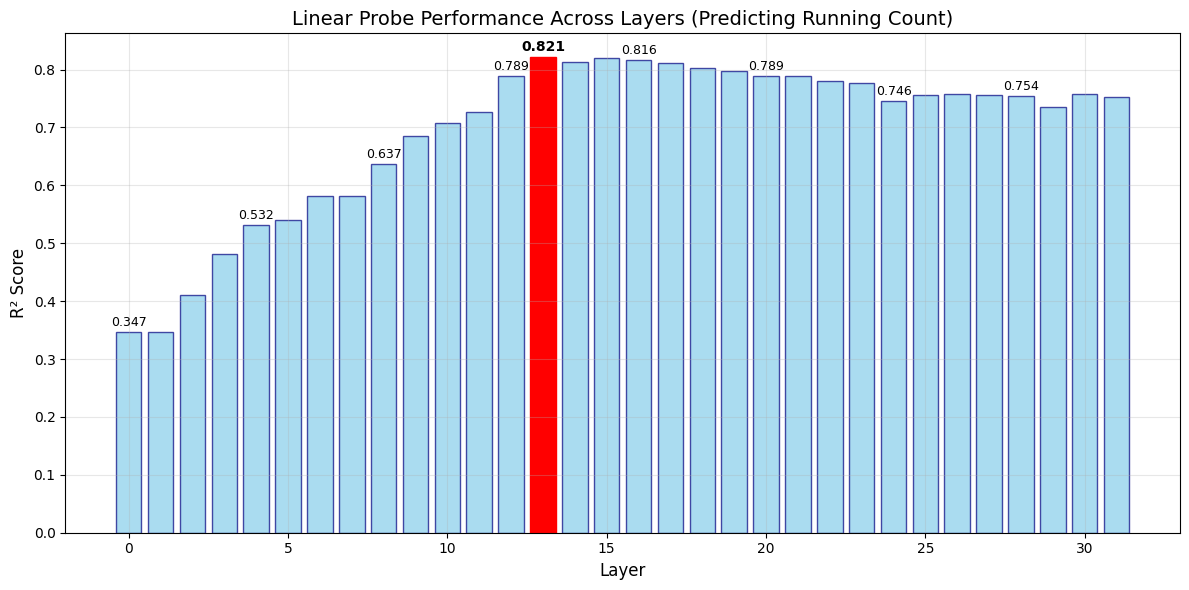


Patching and evaluating...
Evaluating layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

Patching at layer 0...


  0%|                                                            | 0/100 [00:00<?, ?it/s]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġbear', ',', 'Ġlion', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'bear', 'lion', 'sheep', 'tangerine', 'peach']
  Found positions: [31, 34, 36, 38, 40, 44]
  Valid positions: [31, 34, 36, 38, 40, 44]


/tmp/ipykernel_1259488/1956784609.py:186: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision to save memory
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 75%|██████████████████████████████████████▎            | 75/100 [01:52<00:41


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġvehicle', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpear', ',', 'Ġplane', ',', 'Ġpeach', ',']
  Looking for items: ['stool', 'pear', 'plane', 'peach', 'chair', 'dresser', 'scooter']
  Found positions: [31, 34, 36, 38, 40, 42, 44]
  Valid positions: [31, 34, 36, 38, 40, 42, 44]


 82%|█████████████████████████████████████████▊         | 82/100 [02:02<00:25,  1.44s/it]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpiano', ',', 'Ġorange', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'piano', 'orange', 'sheep', 'clarinet', 'truck', 'dresser', 'chair', 'horse', 'harp']
  Found positions: [31, 34, 36, 38, 40, 43, 45, 47, 49, -1]
  Valid positions: [31, 34, 36, 38, 40, 43, 45, 47, 49]


100%|██████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.47s/it]


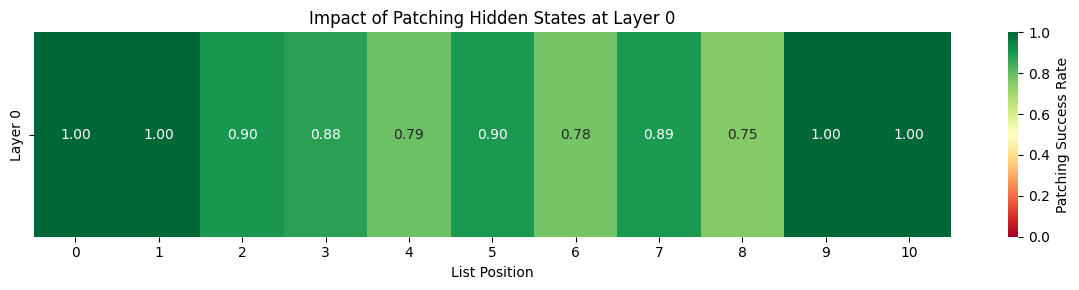


Patching at layer 1...


  0%|                                                            | 0/100 [00:00<?, ?it/s]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġbear', ',', 'Ġlion', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'bear', 'lion', 'sheep', 'tangerine', 'peach']
  Found positions: [31, 34, 36, 38, 40, 44]
  Valid positions: [31, 34, 36, 38, 40, 44]


/tmp/ipykernel_1259488/1956784609.py:186: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision to save memory
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 75%|██████████████████████████████████████▎            | 75/100 [01:51<00:40


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġvehicle', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpear', ',', 'Ġplane', ',', 'Ġpeach', ',']
  Looking for items: ['stool', 'pear', 'plane', 'peach', 'chair', 'dresser', 'scooter']
  Found positions: [31, 34, 36, 38, 40, 42, 44]
  Valid positions: [31, 34, 36, 38, 40, 42, 44]


 82%|█████████████████████████████████████████▊         | 82/100 [02:00<00:27,  1.53s/it]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpiano', ',', 'Ġorange', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'piano', 'orange', 'sheep', 'clarinet', 'truck', 'dresser', 'chair', 'horse', 'harp']
  Found positions: [31, 34, 36, 38, 40, 43, 45, 47, 49, -1]
  Valid positions: [31, 34, 36, 38, 40, 43, 45, 47, 49]


100%|██████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.46s/it]


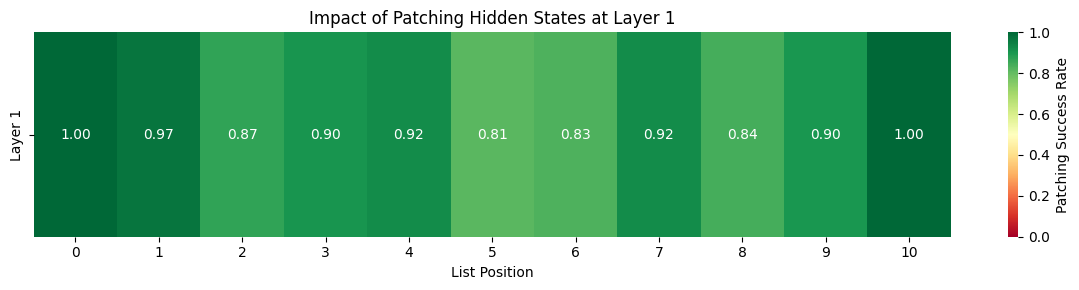


Patching at layer 2...


  0%|                                                            | 0/100 [00:00<?, ?it/s]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġbear', ',', 'Ġlion', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'bear', 'lion', 'sheep', 'tangerine', 'peach']
  Found positions: [31, 34, 36, 38, 40, 44]
  Valid positions: [31, 34, 36, 38, 40, 44]


/tmp/ipykernel_1259488/1956784609.py:186: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision to save memory
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 75%|██████████████████████████████████████▎            | 75/100 [01:49<00:46


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġvehicle', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpear', ',', 'Ġplane', ',', 'Ġpeach', ',']
  Looking for items: ['stool', 'pear', 'plane', 'peach', 'chair', 'dresser', 'scooter']
  Found positions: [31, 34, 36, 38, 40, 42, 44]
  Valid positions: [31, 34, 36, 38, 40, 42, 44]


 82%|█████████████████████████████████████████▊         | 82/100 [01:59<00:25,  1.42s/it]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpiano', ',', 'Ġorange', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'piano', 'orange', 'sheep', 'clarinet', 'truck', 'dresser', 'chair', 'horse', 'harp']
  Found positions: [31, 34, 36, 38, 40, 43, 45, 47, 49, -1]
  Valid positions: [31, 34, 36, 38, 40, 43, 45, 47, 49]


100%|██████████████████████████████████████████████████| 100/100 [02:22<00:00,  1.43s/it]


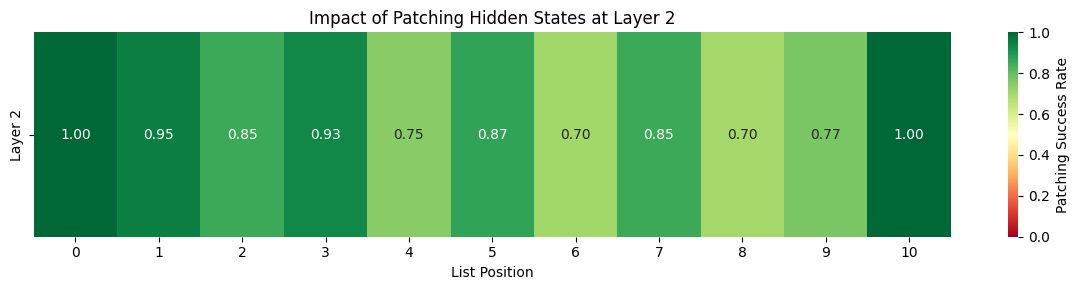


Patching at layer 3...


  0%|                                                            | 0/100 [00:00<?, ?it/s]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġbear', ',', 'Ġlion', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'bear', 'lion', 'sheep', 'tangerine', 'peach']
  Found positions: [31, 34, 36, 38, 40, 44]
  Valid positions: [31, 34, 36, 38, 40, 44]


/tmp/ipykernel_1259488/1956784609.py:186: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision to save memory
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 75%|██████████████████████████████████████▎            | 75/100 [01:46<00:39


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġvehicle', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpear', ',', 'Ġplane', ',', 'Ġpeach', ',']
  Looking for items: ['stool', 'pear', 'plane', 'peach', 'chair', 'dresser', 'scooter']
  Found positions: [31, 34, 36, 38, 40, 42, 44]
  Valid positions: [31, 34, 36, 38, 40, 42, 44]


 82%|█████████████████████████████████████████▊         | 82/100 [01:56<00:25,  1.42s/it]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpiano', ',', 'Ġorange', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'piano', 'orange', 'sheep', 'clarinet', 'truck', 'dresser', 'chair', 'horse', 'harp']
  Found positions: [31, 34, 36, 38, 40, 43, 45, 47, 49, -1]
  Valid positions: [31, 34, 36, 38, 40, 43, 45, 47, 49]


100%|██████████████████████████████████████████████████| 100/100 [02:20<00:00,  1.40s/it]


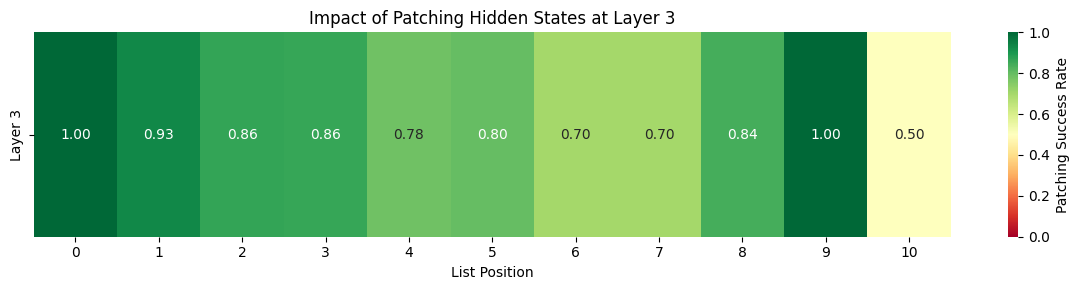


Patching at layer 4...


  0%|                                                            | 0/100 [00:00<?, ?it/s]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġbear', ',', 'Ġlion', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'bear', 'lion', 'sheep', 'tangerine', 'peach']
  Found positions: [31, 34, 36, 38, 40, 44]
  Valid positions: [31, 34, 36, 38, 40, 44]


/tmp/ipykernel_1259488/1956784609.py:186: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision to save memory
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 75%|██████████████████████████████████████▎            | 75/100 [01:47<00:40


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġvehicle', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpear', ',', 'Ġplane', ',', 'Ġpeach', ',']
  Looking for items: ['stool', 'pear', 'plane', 'peach', 'chair', 'dresser', 'scooter']
  Found positions: [31, 34, 36, 38, 40, 42, 44]
  Valid positions: [31, 34, 36, 38, 40, 42, 44]


 82%|█████████████████████████████████████████▊         | 82/100 [01:55<00:21,  1.18s/it]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpiano', ',', 'Ġorange', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'piano', 'orange', 'sheep', 'clarinet', 'truck', 'dresser', 'chair', 'horse', 'harp']
  Found positions: [31, 34, 36, 38, 40, 43, 45, 47, 49, -1]
  Valid positions: [31, 34, 36, 38, 40, 43, 45, 47, 49]


100%|██████████████████████████████████████████████████| 100/100 [02:19<00:00,  1.39s/it]


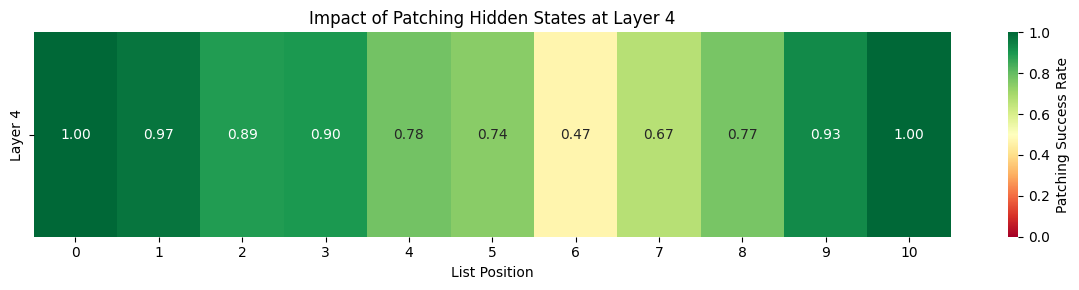


Patching at layer 5...


  0%|                                                            | 0/100 [00:00<?, ?it/s]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġbear', ',', 'Ġlion', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'bear', 'lion', 'sheep', 'tangerine', 'peach']
  Found positions: [31, 34, 36, 38, 40, 44]
  Valid positions: [31, 34, 36, 38, 40, 44]


/tmp/ipykernel_1259488/1956784609.py:186: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision to save memory
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 75%|██████████████████████████████████████▎            | 75/100 [01:44<00:43


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġvehicle', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpear', ',', 'Ġplane', ',', 'Ġpeach', ',']
  Looking for items: ['stool', 'pear', 'plane', 'peach', 'chair', 'dresser', 'scooter']
  Found positions: [31, 34, 36, 38, 40, 42, 44]
  Valid positions: [31, 34, 36, 38, 40, 42, 44]


 82%|█████████████████████████████████████████▊         | 82/100 [01:53<00:25,  1.41s/it]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpiano', ',', 'Ġorange', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'piano', 'orange', 'sheep', 'clarinet', 'truck', 'dresser', 'chair', 'horse', 'harp']
  Found positions: [31, 34, 36, 38, 40, 43, 45, 47, 49, -1]
  Valid positions: [31, 34, 36, 38, 40, 43, 45, 47, 49]


100%|██████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.38s/it]


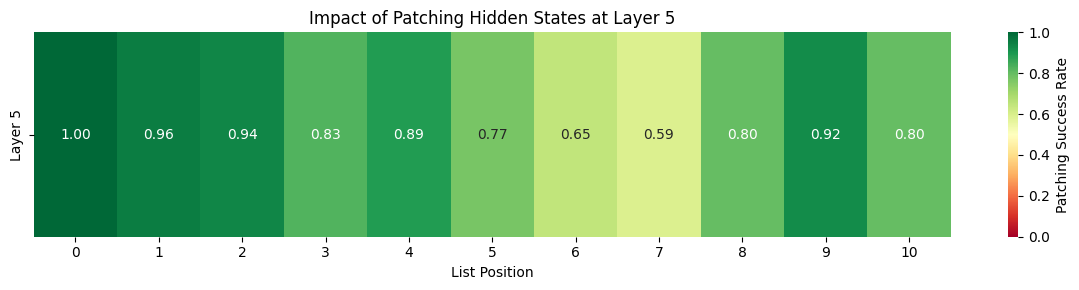


Patching at layer 6...


  0%|                                                            | 0/100 [00:00<?, ?it/s]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġbear', ',', 'Ġlion', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'bear', 'lion', 'sheep', 'tangerine', 'peach']
  Found positions: [31, 34, 36, 38, 40, 44]
  Valid positions: [31, 34, 36, 38, 40, 44]


/tmp/ipykernel_1259488/1956784609.py:186: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision to save memory
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 75%|██████████████████████████████████████▎            | 75/100 [01:53<00:47


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġvehicle', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpear', ',', 'Ġplane', ',', 'Ġpeach', ',']
  Looking for items: ['stool', 'pear', 'plane', 'peach', 'chair', 'dresser', 'scooter']
  Found positions: [31, 34, 36, 38, 40, 42, 44]
  Valid positions: [31, 34, 36, 38, 40, 42, 44]


 82%|█████████████████████████████████████████▊         | 82/100 [02:02<00:25,  1.40s/it]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpiano', ',', 'Ġorange', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'piano', 'orange', 'sheep', 'clarinet', 'truck', 'dresser', 'chair', 'horse', 'harp']
  Found positions: [31, 34, 36, 38, 40, 43, 45, 47, 49, -1]
  Valid positions: [31, 34, 36, 38, 40, 43, 45, 47, 49]


100%|██████████████████████████████████████████████████| 100/100 [02:28<00:00,  1.48s/it]


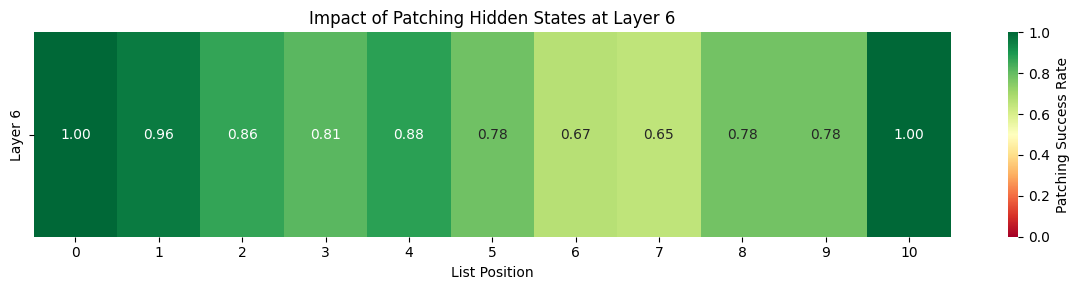


Patching at layer 7...


  0%|                                                            | 0/100 [00:00<?, ?it/s]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġbear', ',', 'Ġlion', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'bear', 'lion', 'sheep', 'tangerine', 'peach']
  Found positions: [31, 34, 36, 38, 40, 44]
  Valid positions: [31, 34, 36, 38, 40, 44]


/tmp/ipykernel_1259488/1956784609.py:186: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision to save memory
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 75%|██████████████████████████████████████▎            | 75/100 [01:51<00:41


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġvehicle', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpear', ',', 'Ġplane', ',', 'Ġpeach', ',']
  Looking for items: ['stool', 'pear', 'plane', 'peach', 'chair', 'dresser', 'scooter']
  Found positions: [31, 34, 36, 38, 40, 42, 44]
  Valid positions: [31, 34, 36, 38, 40, 42, 44]


 82%|█████████████████████████████████████████▊         | 82/100 [02:01<00:27,  1.52s/it]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpiano', ',', 'Ġorange', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'piano', 'orange', 'sheep', 'clarinet', 'truck', 'dresser', 'chair', 'horse', 'harp']
  Found positions: [31, 34, 36, 38, 40, 43, 45, 47, 49, -1]
  Valid positions: [31, 34, 36, 38, 40, 43, 45, 47, 49]


100%|██████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.46s/it]


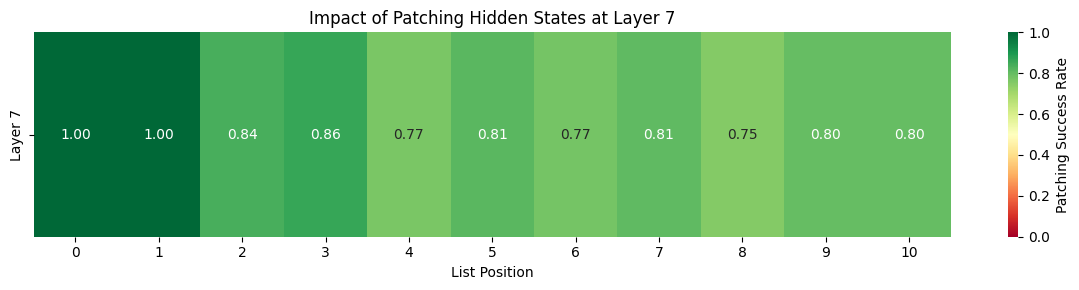


Patching at layer 8...


  0%|                                                            | 0/100 [00:00<?, ?it/s]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġbear', ',', 'Ġlion', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'bear', 'lion', 'sheep', 'tangerine', 'peach']
  Found positions: [31, 34, 36, 38, 40, 44]
  Valid positions: [31, 34, 36, 38, 40, 44]


/tmp/ipykernel_1259488/1956784609.py:186: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision to save memory
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 75%|██████████████████████████████████████▎            | 75/100 [01:49<00:35


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġvehicle', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpear', ',', 'Ġplane', ',', 'Ġpeach', ',']
  Looking for items: ['stool', 'pear', 'plane', 'peach', 'chair', 'dresser', 'scooter']
  Found positions: [31, 34, 36, 38, 40, 42, 44]
  Valid positions: [31, 34, 36, 38, 40, 42, 44]


 82%|█████████████████████████████████████████▊         | 82/100 [01:59<00:23,  1.30s/it]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpiano', ',', 'Ġorange', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'piano', 'orange', 'sheep', 'clarinet', 'truck', 'dresser', 'chair', 'horse', 'harp']
  Found positions: [31, 34, 36, 38, 40, 43, 45, 47, 49, -1]
  Valid positions: [31, 34, 36, 38, 40, 43, 45, 47, 49]


100%|██████████████████████████████████████████████████| 100/100 [02:22<00:00,  1.43s/it]


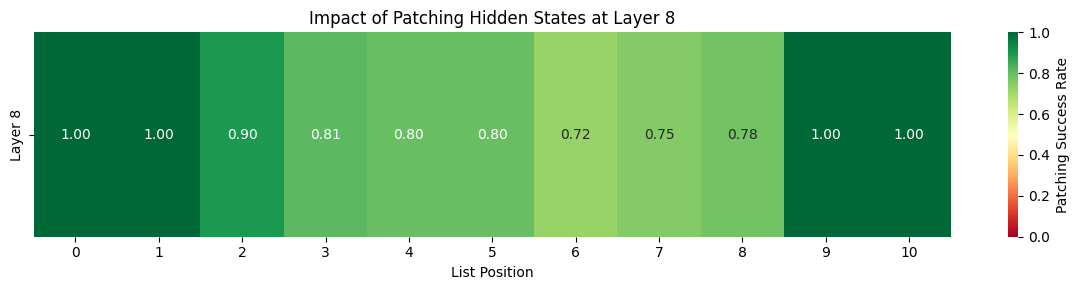


Patching at layer 9...


  0%|                                                            | 0/100 [00:00<?, ?it/s]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġbear', ',', 'Ġlion', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'bear', 'lion', 'sheep', 'tangerine', 'peach']
  Found positions: [31, 34, 36, 38, 40, 44]
  Valid positions: [31, 34, 36, 38, 40, 44]


/tmp/ipykernel_1259488/1956784609.py:186: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision to save memory
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 75%|██████████████████████████████████████▎            | 75/100 [01:43<00:39


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġvehicle', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpear', ',', 'Ġplane', ',', 'Ġpeach', ',']
  Looking for items: ['stool', 'pear', 'plane', 'peach', 'chair', 'dresser', 'scooter']
  Found positions: [31, 34, 36, 38, 40, 42, 44]
  Valid positions: [31, 34, 36, 38, 40, 42, 44]


 82%|█████████████████████████████████████████▊         | 82/100 [01:53<00:27,  1.53s/it]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpiano', ',', 'Ġorange', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'piano', 'orange', 'sheep', 'clarinet', 'truck', 'dresser', 'chair', 'horse', 'harp']
  Found positions: [31, 34, 36, 38, 40, 43, 45, 47, 49, -1]
  Valid positions: [31, 34, 36, 38, 40, 43, 45, 47, 49]


100%|██████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.39s/it]


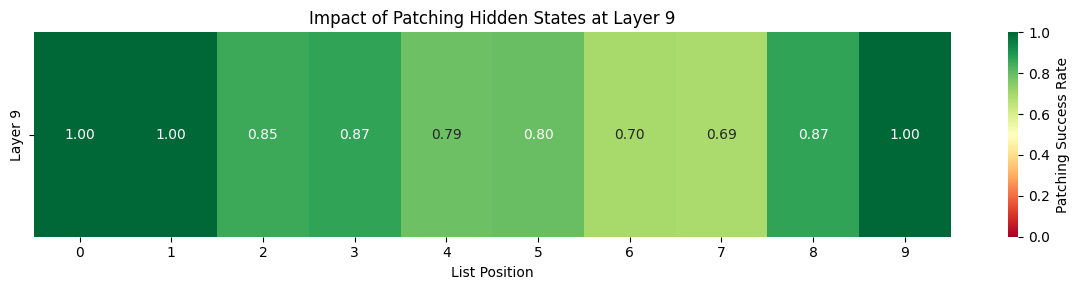


Patching at layer 10...


  0%|                                                            | 0/100 [00:00<?, ?it/s]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġbear', ',', 'Ġlion', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'bear', 'lion', 'sheep', 'tangerine', 'peach']
  Found positions: [31, 34, 36, 38, 40, 44]
  Valid positions: [31, 34, 36, 38, 40, 44]


/tmp/ipykernel_1259488/1956784609.py:186: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision to save memory
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 75%|██████████████████████████████████████▎            | 75/100 [01:45<00:39


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġvehicle', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpear', ',', 'Ġplane', ',', 'Ġpeach', ',']
  Looking for items: ['stool', 'pear', 'plane', 'peach', 'chair', 'dresser', 'scooter']
  Found positions: [31, 34, 36, 38, 40, 42, 44]
  Valid positions: [31, 34, 36, 38, 40, 42, 44]


 82%|█████████████████████████████████████████▊         | 82/100 [01:55<00:27,  1.55s/it]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpiano', ',', 'Ġorange', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'piano', 'orange', 'sheep', 'clarinet', 'truck', 'dresser', 'chair', 'horse', 'harp']
  Found positions: [31, 34, 36, 38, 40, 43, 45, 47, 49, -1]
  Valid positions: [31, 34, 36, 38, 40, 43, 45, 47, 49]


100%|██████████████████████████████████████████████████| 100/100 [02:21<00:00,  1.42s/it]


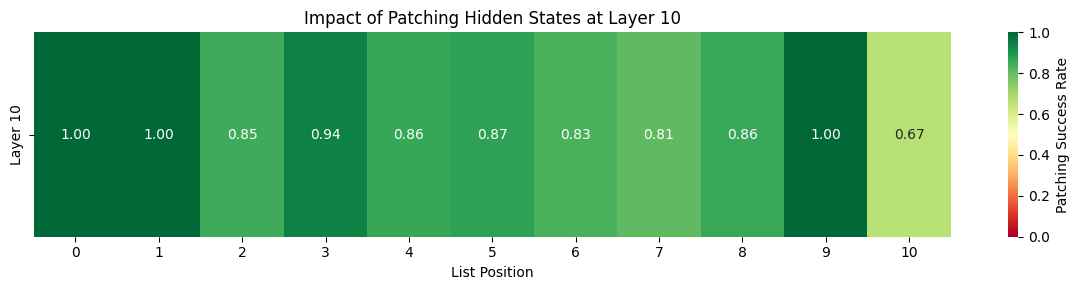


Patching at layer 11...


  0%|                                                            | 0/100 [00:00<?, ?it/s]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġbear', ',', 'Ġlion', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'bear', 'lion', 'sheep', 'tangerine', 'peach']
  Found positions: [31, 34, 36, 38, 40, 44]
  Valid positions: [31, 34, 36, 38, 40, 44]


/tmp/ipykernel_1259488/1956784609.py:186: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision to save memory
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 75%|██████████████████████████████████████▎            | 75/100 [01:48<00:40


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġvehicle', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpear', ',', 'Ġplane', ',', 'Ġpeach', ',']
  Looking for items: ['stool', 'pear', 'plane', 'peach', 'chair', 'dresser', 'scooter']
  Found positions: [31, 34, 36, 38, 40, 42, 44]
  Valid positions: [31, 34, 36, 38, 40, 42, 44]


 82%|█████████████████████████████████████████▊         | 82/100 [01:57<00:24,  1.35s/it]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpiano', ',', 'Ġorange', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'piano', 'orange', 'sheep', 'clarinet', 'truck', 'dresser', 'chair', 'horse', 'harp']
  Found positions: [31, 34, 36, 38, 40, 43, 45, 47, 49, -1]
  Valid positions: [31, 34, 36, 38, 40, 43, 45, 47, 49]


100%|██████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.44s/it]


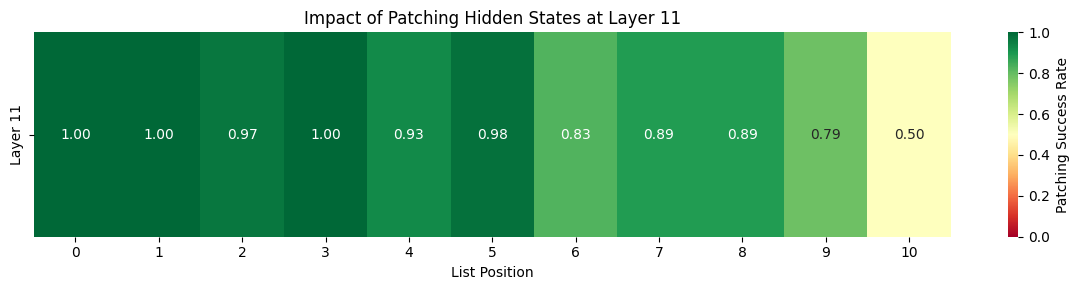


Patching at layer 12...


  0%|                                                            | 0/100 [00:00<?, ?it/s]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġbear', ',', 'Ġlion', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'bear', 'lion', 'sheep', 'tangerine', 'peach']
  Found positions: [31, 34, 36, 38, 40, 44]
  Valid positions: [31, 34, 36, 38, 40, 44]


/tmp/ipykernel_1259488/1956784609.py:186: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision to save memory
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 75%|██████████████████████████████████████▎            | 75/100 [01:41<00:35


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġvehicle', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpear', ',', 'Ġplane', ',', 'Ġpeach', ',']
  Looking for items: ['stool', 'pear', 'plane', 'peach', 'chair', 'dresser', 'scooter']
  Found positions: [31, 34, 36, 38, 40, 42, 44]
  Valid positions: [31, 34, 36, 38, 40, 42, 44]


 82%|█████████████████████████████████████████▊         | 82/100 [01:51<00:26,  1.48s/it]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpiano', ',', 'Ġorange', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'piano', 'orange', 'sheep', 'clarinet', 'truck', 'dresser', 'chair', 'horse', 'harp']
  Found positions: [31, 34, 36, 38, 40, 43, 45, 47, 49, -1]
  Valid positions: [31, 34, 36, 38, 40, 43, 45, 47, 49]


100%|██████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.38s/it]


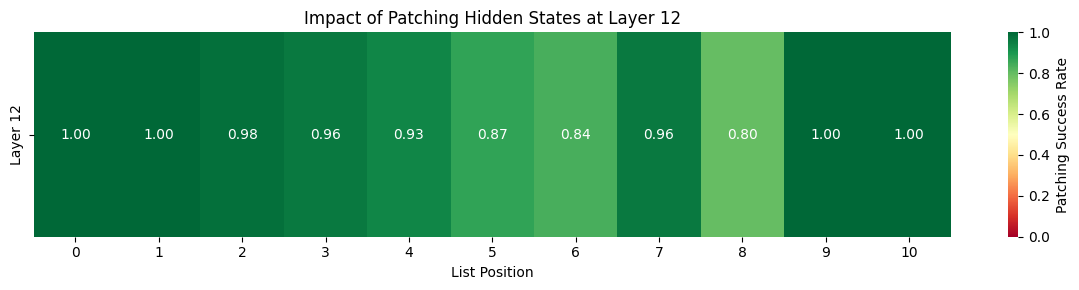


Patching at layer 13...


  0%|                                                            | 0/100 [00:00<?, ?it/s]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġbear', ',', 'Ġlion', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'bear', 'lion', 'sheep', 'tangerine', 'peach']
  Found positions: [31, 34, 36, 38, 40, 44]
  Valid positions: [31, 34, 36, 38, 40, 44]


/tmp/ipykernel_1259488/1956784609.py:186: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision to save memory
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 75%|██████████████████████████████████████▎            | 75/100 [01:46<00:44


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġvehicle', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpear', ',', 'Ġplane', ',', 'Ġpeach', ',']
  Looking for items: ['stool', 'pear', 'plane', 'peach', 'chair', 'dresser', 'scooter']
  Found positions: [31, 34, 36, 38, 40, 42, 44]
  Valid positions: [31, 34, 36, 38, 40, 42, 44]


 82%|█████████████████████████████████████████▊         | 82/100 [01:57<00:25,  1.44s/it]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpiano', ',', 'Ġorange', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'piano', 'orange', 'sheep', 'clarinet', 'truck', 'dresser', 'chair', 'horse', 'harp']
  Found positions: [31, 34, 36, 38, 40, 43, 45, 47, 49, -1]
  Valid positions: [31, 34, 36, 38, 40, 43, 45, 47, 49]


100%|██████████████████████████████████████████████████| 100/100 [02:20<00:00,  1.41s/it]


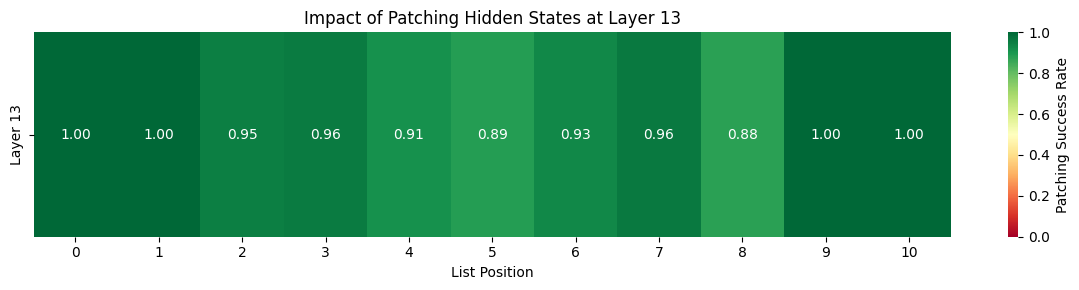


Patching at layer 14...


  0%|                                                            | 0/100 [00:00<?, ?it/s]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġbear', ',', 'Ġlion', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'bear', 'lion', 'sheep', 'tangerine', 'peach']
  Found positions: [31, 34, 36, 38, 40, 44]
  Valid positions: [31, 34, 36, 38, 40, 44]


/tmp/ipykernel_1259488/1956784609.py:186: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision to save memory
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 75%|██████████████████████████████████████▎            | 75/100 [01:49<00:41


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġvehicle', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpear', ',', 'Ġplane', ',', 'Ġpeach', ',']
  Looking for items: ['stool', 'pear', 'plane', 'peach', 'chair', 'dresser', 'scooter']
  Found positions: [31, 34, 36, 38, 40, 42, 44]
  Valid positions: [31, 34, 36, 38, 40, 42, 44]


 82%|█████████████████████████████████████████▊         | 82/100 [01:58<00:24,  1.34s/it]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpiano', ',', 'Ġorange', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'piano', 'orange', 'sheep', 'clarinet', 'truck', 'dresser', 'chair', 'horse', 'harp']
  Found positions: [31, 34, 36, 38, 40, 43, 45, 47, 49, -1]
  Valid positions: [31, 34, 36, 38, 40, 43, 45, 47, 49]


100%|██████████████████████████████████████████████████| 100/100 [02:22<00:00,  1.42s/it]


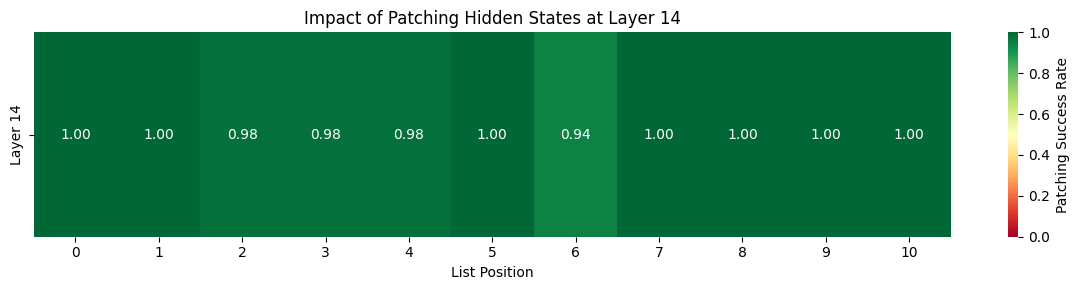


Patching at layer 15...


  0%|                                                            | 0/100 [00:00<?, ?it/s]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġbear', ',', 'Ġlion', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'bear', 'lion', 'sheep', 'tangerine', 'peach']
  Found positions: [31, 34, 36, 38, 40, 44]
  Valid positions: [31, 34, 36, 38, 40, 44]


/tmp/ipykernel_1259488/1956784609.py:186: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision to save memory
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 75%|██████████████████████████████████████▎            | 75/100 [01:46<00:41


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġvehicle', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpear', ',', 'Ġplane', ',', 'Ġpeach', ',']
  Looking for items: ['stool', 'pear', 'plane', 'peach', 'chair', 'dresser', 'scooter']
  Found positions: [31, 34, 36, 38, 40, 42, 44]
  Valid positions: [31, 34, 36, 38, 40, 42, 44]


 82%|█████████████████████████████████████████▊         | 82/100 [01:55<00:26,  1.46s/it]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpiano', ',', 'Ġorange', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'piano', 'orange', 'sheep', 'clarinet', 'truck', 'dresser', 'chair', 'horse', 'harp']
  Found positions: [31, 34, 36, 38, 40, 43, 45, 47, 49, -1]
  Valid positions: [31, 34, 36, 38, 40, 43, 45, 47, 49]


100%|██████████████████████████████████████████████████| 100/100 [02:21<00:00,  1.42s/it]


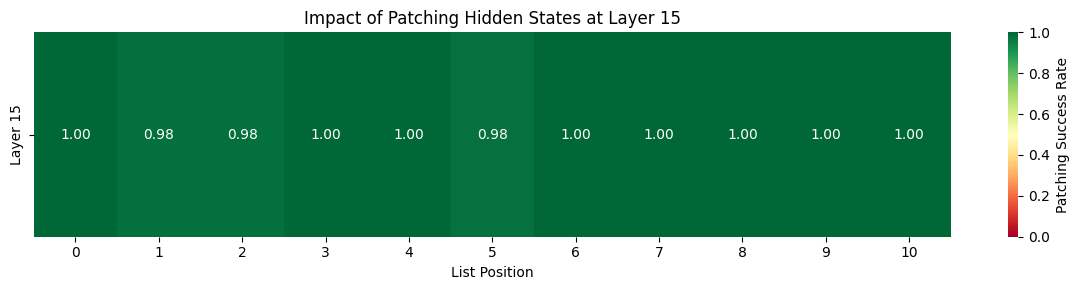


Patching at layer 16...


  0%|                                                            | 0/100 [00:00<?, ?it/s]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġbear', ',', 'Ġlion', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'bear', 'lion', 'sheep', 'tangerine', 'peach']
  Found positions: [31, 34, 36, 38, 40, 44]
  Valid positions: [31, 34, 36, 38, 40, 44]


/tmp/ipykernel_1259488/1956784609.py:186: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision to save memory
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 75%|██████████████████████████████████████▎            | 75/100 [01:50<00:38


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġvehicle', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpear', ',', 'Ġplane', ',', 'Ġpeach', ',']
  Looking for items: ['stool', 'pear', 'plane', 'peach', 'chair', 'dresser', 'scooter']
  Found positions: [31, 34, 36, 38, 40, 42, 44]
  Valid positions: [31, 34, 36, 38, 40, 42, 44]


 82%|█████████████████████████████████████████▊         | 82/100 [02:00<00:29,  1.62s/it]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpiano', ',', 'Ġorange', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'piano', 'orange', 'sheep', 'clarinet', 'truck', 'dresser', 'chair', 'horse', 'harp']
  Found positions: [31, 34, 36, 38, 40, 43, 45, 47, 49, -1]
  Valid positions: [31, 34, 36, 38, 40, 43, 45, 47, 49]


100%|██████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.46s/it]


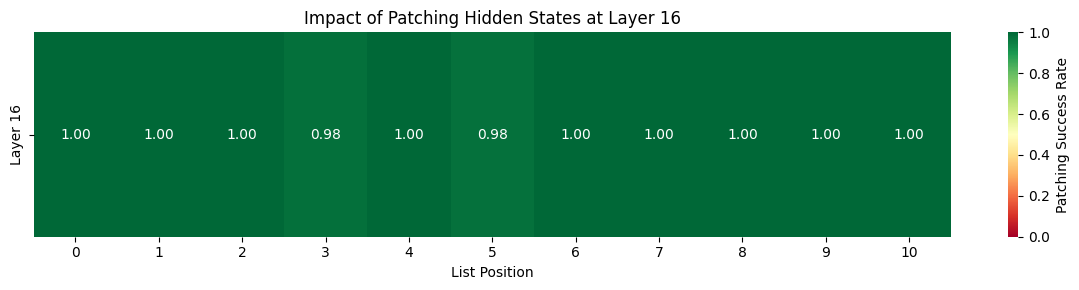


Patching at layer 17...


  0%|                                                            | 0/100 [00:00<?, ?it/s]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġbear', ',', 'Ġlion', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'bear', 'lion', 'sheep', 'tangerine', 'peach']
  Found positions: [31, 34, 36, 38, 40, 44]
  Valid positions: [31, 34, 36, 38, 40, 44]


/tmp/ipykernel_1259488/1956784609.py:186: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision to save memory
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 75%|██████████████████████████████████████▎            | 75/100 [01:50<00:44


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġvehicle', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpear', ',', 'Ġplane', ',', 'Ġpeach', ',']
  Looking for items: ['stool', 'pear', 'plane', 'peach', 'chair', 'dresser', 'scooter']
  Found positions: [31, 34, 36, 38, 40, 42, 44]
  Valid positions: [31, 34, 36, 38, 40, 42, 44]


 82%|█████████████████████████████████████████▊         | 82/100 [01:59<00:28,  1.56s/it]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpiano', ',', 'Ġorange', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'piano', 'orange', 'sheep', 'clarinet', 'truck', 'dresser', 'chair', 'horse', 'harp']
  Found positions: [31, 34, 36, 38, 40, 43, 45, 47, 49, -1]
  Valid positions: [31, 34, 36, 38, 40, 43, 45, 47, 49]


100%|██████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.43s/it]


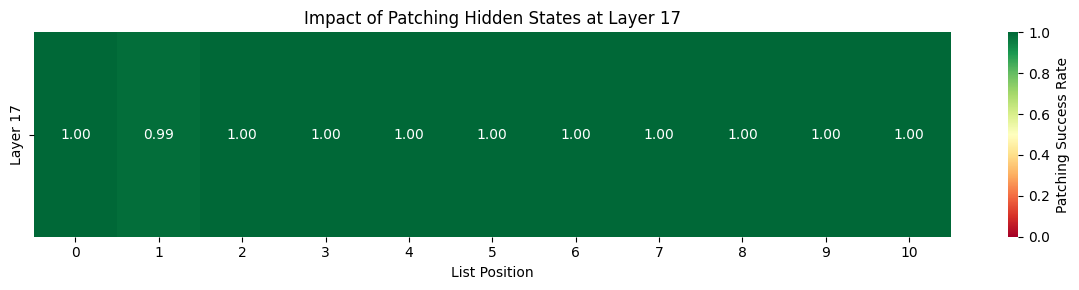


Patching at layer 18...


  0%|                                                            | 0/100 [00:00<?, ?it/s]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġbear', ',', 'Ġlion', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'bear', 'lion', 'sheep', 'tangerine', 'peach']
  Found positions: [31, 34, 36, 38, 40, 44]
  Valid positions: [31, 34, 36, 38, 40, 44]


/tmp/ipykernel_1259488/1956784609.py:186: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision to save memory
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 75%|██████████████████████████████████████▎            | 75/100 [01:42<00:40


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġvehicle', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpear', ',', 'Ġplane', ',', 'Ġpeach', ',']
  Looking for items: ['stool', 'pear', 'plane', 'peach', 'chair', 'dresser', 'scooter']
  Found positions: [31, 34, 36, 38, 40, 42, 44]
  Valid positions: [31, 34, 36, 38, 40, 42, 44]


 82%|█████████████████████████████████████████▊         | 82/100 [01:52<00:25,  1.44s/it]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpiano', ',', 'Ġorange', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'piano', 'orange', 'sheep', 'clarinet', 'truck', 'dresser', 'chair', 'horse', 'harp']
  Found positions: [31, 34, 36, 38, 40, 43, 45, 47, 49, -1]
  Valid positions: [31, 34, 36, 38, 40, 43, 45, 47, 49]


100%|██████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.39s/it]


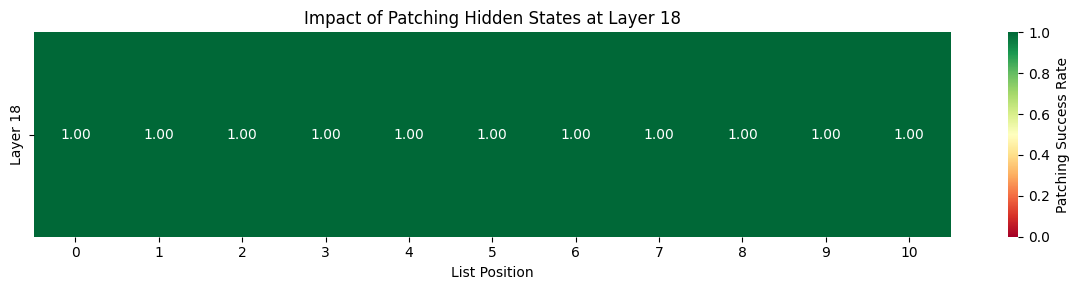


Patching at layer 19...


  0%|                                                            | 0/100 [00:00<?, ?it/s]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġbear', ',', 'Ġlion', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'bear', 'lion', 'sheep', 'tangerine', 'peach']
  Found positions: [31, 34, 36, 38, 40, 44]
  Valid positions: [31, 34, 36, 38, 40, 44]


/tmp/ipykernel_1259488/1956784609.py:186: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision to save memory
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 75%|██████████████████████████████████████▎            | 75/100 [01:45<00:41


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġvehicle', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpear', ',', 'Ġplane', ',', 'Ġpeach', ',']
  Looking for items: ['stool', 'pear', 'plane', 'peach', 'chair', 'dresser', 'scooter']
  Found positions: [31, 34, 36, 38, 40, 42, 44]
  Valid positions: [31, 34, 36, 38, 40, 42, 44]


 82%|█████████████████████████████████████████▊         | 82/100 [01:56<00:28,  1.61s/it]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpiano', ',', 'Ġorange', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'piano', 'orange', 'sheep', 'clarinet', 'truck', 'dresser', 'chair', 'horse', 'harp']
  Found positions: [31, 34, 36, 38, 40, 43, 45, 47, 49, -1]
  Valid positions: [31, 34, 36, 38, 40, 43, 45, 47, 49]


100%|██████████████████████████████████████████████████| 100/100 [02:21<00:00,  1.41s/it]


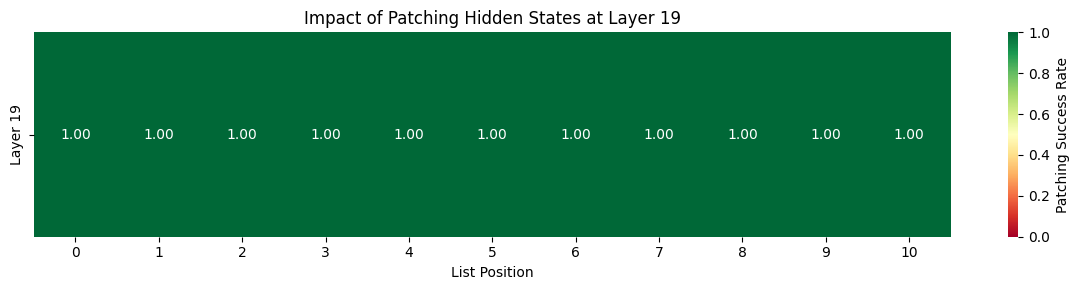


Patching at layer 20...


  0%|                                                            | 0/100 [00:00<?, ?it/s]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġbear', ',', 'Ġlion', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'bear', 'lion', 'sheep', 'tangerine', 'peach']
  Found positions: [31, 34, 36, 38, 40, 44]
  Valid positions: [31, 34, 36, 38, 40, 44]


/tmp/ipykernel_1259488/1956784609.py:186: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision to save memory
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 75%|██████████████████████████████████████▎            | 75/100 [01:48<00:38


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġvehicle', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpear', ',', 'Ġplane', ',', 'Ġpeach', ',']
  Looking for items: ['stool', 'pear', 'plane', 'peach', 'chair', 'dresser', 'scooter']
  Found positions: [31, 34, 36, 38, 40, 42, 44]
  Valid positions: [31, 34, 36, 38, 40, 42, 44]


 82%|█████████████████████████████████████████▊         | 82/100 [01:58<00:27,  1.55s/it]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpiano', ',', 'Ġorange', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'piano', 'orange', 'sheep', 'clarinet', 'truck', 'dresser', 'chair', 'horse', 'harp']
  Found positions: [31, 34, 36, 38, 40, 43, 45, 47, 49, -1]
  Valid positions: [31, 34, 36, 38, 40, 43, 45, 47, 49]


100%|██████████████████████████████████████████████████| 100/100 [02:19<00:00,  1.40s/it]


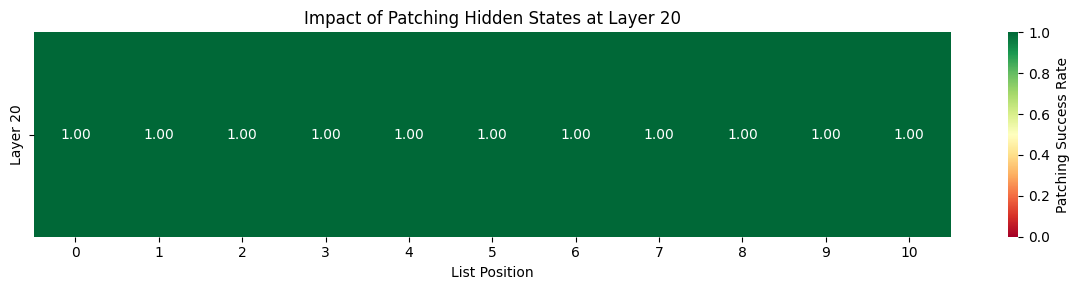


Patching at layer 21...


  0%|                                                            | 0/100 [00:00<?, ?it/s]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġbear', ',', 'Ġlion', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'bear', 'lion', 'sheep', 'tangerine', 'peach']
  Found positions: [31, 34, 36, 38, 40, 44]
  Valid positions: [31, 34, 36, 38, 40, 44]


/tmp/ipykernel_1259488/1956784609.py:186: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision to save memory
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 75%|██████████████████████████████████████▎            | 75/100 [01:48<00:44


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġvehicle', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpear', ',', 'Ġplane', ',', 'Ġpeach', ',']
  Looking for items: ['stool', 'pear', 'plane', 'peach', 'chair', 'dresser', 'scooter']
  Found positions: [31, 34, 36, 38, 40, 42, 44]
  Valid positions: [31, 34, 36, 38, 40, 42, 44]


 82%|█████████████████████████████████████████▊         | 82/100 [01:59<00:28,  1.60s/it]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpiano', ',', 'Ġorange', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'piano', 'orange', 'sheep', 'clarinet', 'truck', 'dresser', 'chair', 'horse', 'harp']
  Found positions: [31, 34, 36, 38, 40, 43, 45, 47, 49, -1]
  Valid positions: [31, 34, 36, 38, 40, 43, 45, 47, 49]


100%|██████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.46s/it]


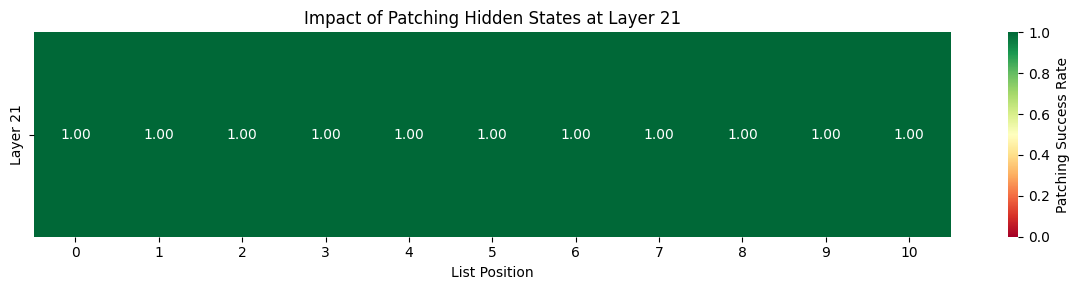


Patching at layer 22...


  0%|                                                            | 0/100 [00:00<?, ?it/s]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġbear', ',', 'Ġlion', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'bear', 'lion', 'sheep', 'tangerine', 'peach']
  Found positions: [31, 34, 36, 38, 40, 44]
  Valid positions: [31, 34, 36, 38, 40, 44]


/tmp/ipykernel_1259488/1956784609.py:186: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision to save memory
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 75%|██████████████████████████████████████▎            | 75/100 [01:58<00:45


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġvehicle', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpear', ',', 'Ġplane', ',', 'Ġpeach', ',']
  Looking for items: ['stool', 'pear', 'plane', 'peach', 'chair', 'dresser', 'scooter']
  Found positions: [31, 34, 36, 38, 40, 42, 44]
  Valid positions: [31, 34, 36, 38, 40, 42, 44]


 82%|█████████████████████████████████████████▊         | 82/100 [02:07<00:22,  1.27s/it]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpiano', ',', 'Ġorange', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'piano', 'orange', 'sheep', 'clarinet', 'truck', 'dresser', 'chair', 'horse', 'harp']
  Found positions: [31, 34, 36, 38, 40, 43, 45, 47, 49, -1]
  Valid positions: [31, 34, 36, 38, 40, 43, 45, 47, 49]


100%|██████████████████████████████████████████████████| 100/100 [02:30<00:00,  1.50s/it]


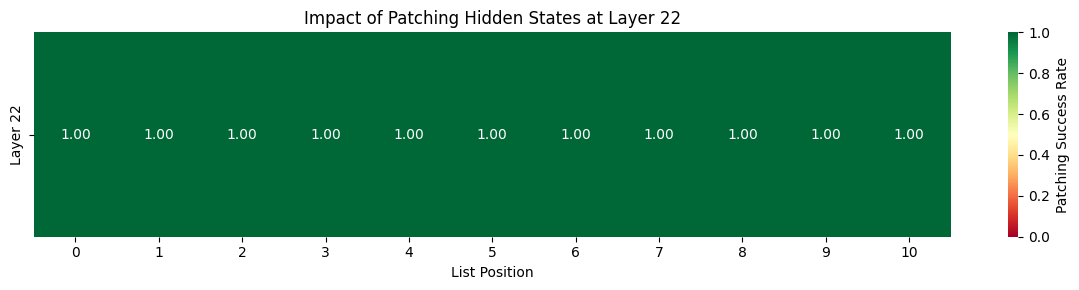


Patching at layer 23...


  0%|                                                            | 0/100 [00:00<?, ?it/s]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġbear', ',', 'Ġlion', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'bear', 'lion', 'sheep', 'tangerine', 'peach']
  Found positions: [31, 34, 36, 38, 40, 44]
  Valid positions: [31, 34, 36, 38, 40, 44]


/tmp/ipykernel_1259488/1956784609.py:186: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision to save memory
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 75%|██████████████████████████████████████▎            | 75/100 [01:48<00:37


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġvehicle', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpear', ',', 'Ġplane', ',', 'Ġpeach', ',']
  Looking for items: ['stool', 'pear', 'plane', 'peach', 'chair', 'dresser', 'scooter']
  Found positions: [31, 34, 36, 38, 40, 42, 44]
  Valid positions: [31, 34, 36, 38, 40, 42, 44]


 82%|█████████████████████████████████████████▊         | 82/100 [01:57<00:25,  1.43s/it]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpiano', ',', 'Ġorange', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'piano', 'orange', 'sheep', 'clarinet', 'truck', 'dresser', 'chair', 'horse', 'harp']
  Found positions: [31, 34, 36, 38, 40, 43, 45, 47, 49, -1]
  Valid positions: [31, 34, 36, 38, 40, 43, 45, 47, 49]


100%|██████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.43s/it]


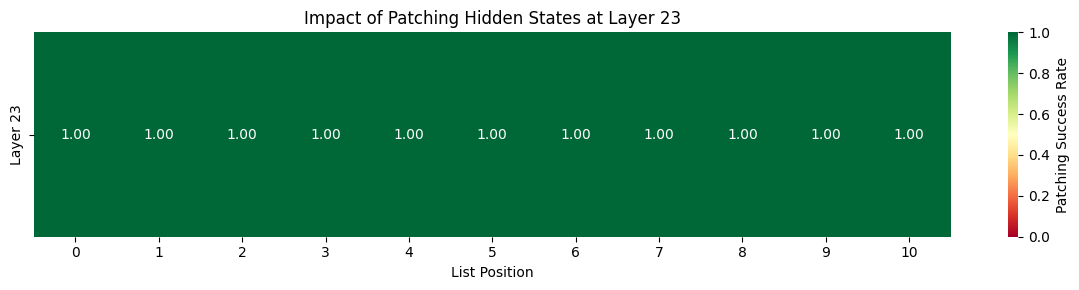


Patching at layer 24...


  0%|                                                            | 0/100 [00:00<?, ?it/s]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġbear', ',', 'Ġlion', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'bear', 'lion', 'sheep', 'tangerine', 'peach']
  Found positions: [31, 34, 36, 38, 40, 44]
  Valid positions: [31, 34, 36, 38, 40, 44]


/tmp/ipykernel_1259488/1956784609.py:186: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision to save memory
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 75%|██████████████████████████████████████▎            | 75/100 [01:45<00:40


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġvehicle', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpear', ',', 'Ġplane', ',', 'Ġpeach', ',']
  Looking for items: ['stool', 'pear', 'plane', 'peach', 'chair', 'dresser', 'scooter']
  Found positions: [31, 34, 36, 38, 40, 42, 44]
  Valid positions: [31, 34, 36, 38, 40, 42, 44]


 82%|█████████████████████████████████████████▊         | 82/100 [01:55<00:25,  1.43s/it]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpiano', ',', 'Ġorange', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'piano', 'orange', 'sheep', 'clarinet', 'truck', 'dresser', 'chair', 'horse', 'harp']
  Found positions: [31, 34, 36, 38, 40, 43, 45, 47, 49, -1]
  Valid positions: [31, 34, 36, 38, 40, 43, 45, 47, 49]


100%|██████████████████████████████████████████████████| 100/100 [02:22<00:00,  1.42s/it]


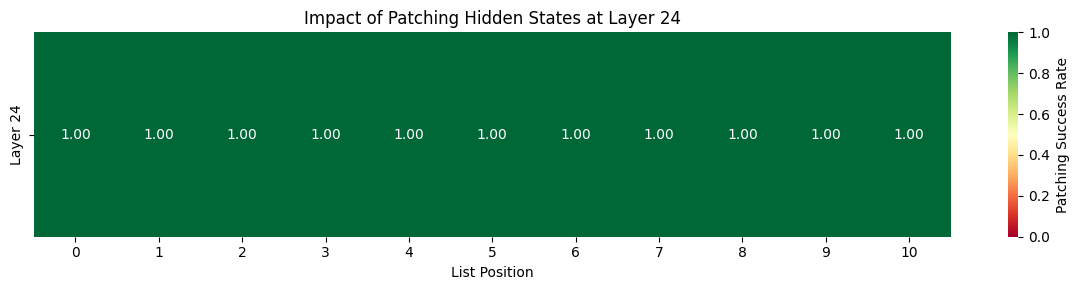


Patching at layer 25...


  0%|                                                            | 0/100 [00:00<?, ?it/s]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġbear', ',', 'Ġlion', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'bear', 'lion', 'sheep', 'tangerine', 'peach']
  Found positions: [31, 34, 36, 38, 40, 44]
  Valid positions: [31, 34, 36, 38, 40, 44]


/tmp/ipykernel_1259488/1956784609.py:186: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision to save memory
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 75%|██████████████████████████████████████▎            | 75/100 [01:48<00:40


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġvehicle', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpear', ',', 'Ġplane', ',', 'Ġpeach', ',']
  Looking for items: ['stool', 'pear', 'plane', 'peach', 'chair', 'dresser', 'scooter']
  Found positions: [31, 34, 36, 38, 40, 42, 44]
  Valid positions: [31, 34, 36, 38, 40, 42, 44]


 82%|█████████████████████████████████████████▊         | 82/100 [01:56<00:24,  1.34s/it]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpiano', ',', 'Ġorange', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'piano', 'orange', 'sheep', 'clarinet', 'truck', 'dresser', 'chair', 'horse', 'harp']
  Found positions: [31, 34, 36, 38, 40, 43, 45, 47, 49, -1]
  Valid positions: [31, 34, 36, 38, 40, 43, 45, 47, 49]


100%|██████████████████████████████████████████████████| 100/100 [02:21<00:00,  1.41s/it]


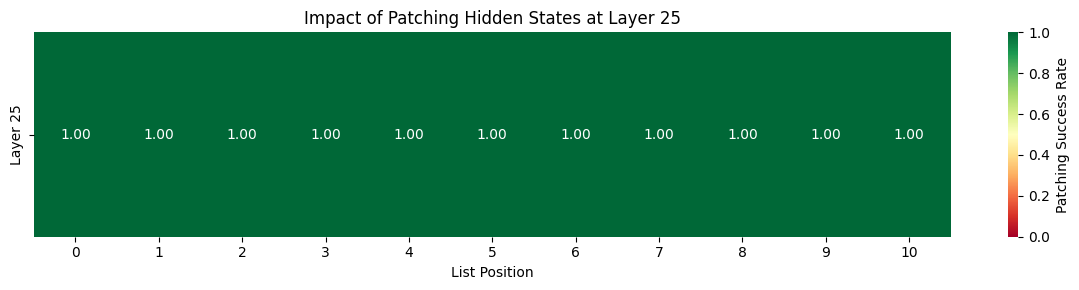


Patching at layer 26...


  0%|                                                            | 0/100 [00:00<?, ?it/s]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġbear', ',', 'Ġlion', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'bear', 'lion', 'sheep', 'tangerine', 'peach']
  Found positions: [31, 34, 36, 38, 40, 44]
  Valid positions: [31, 34, 36, 38, 40, 44]


/tmp/ipykernel_1259488/1956784609.py:186: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision to save memory
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 75%|██████████████████████████████████████▎            | 75/100 [01:43<00:31


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġvehicle', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpear', ',', 'Ġplane', ',', 'Ġpeach', ',']
  Looking for items: ['stool', 'pear', 'plane', 'peach', 'chair', 'dresser', 'scooter']
  Found positions: [31, 34, 36, 38, 40, 42, 44]
  Valid positions: [31, 34, 36, 38, 40, 42, 44]


 82%|█████████████████████████████████████████▊         | 82/100 [01:53<00:28,  1.59s/it]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpiano', ',', 'Ġorange', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'piano', 'orange', 'sheep', 'clarinet', 'truck', 'dresser', 'chair', 'horse', 'harp']
  Found positions: [31, 34, 36, 38, 40, 43, 45, 47, 49, -1]
  Valid positions: [31, 34, 36, 38, 40, 43, 45, 47, 49]


100%|██████████████████████████████████████████████████| 100/100 [02:22<00:00,  1.43s/it]


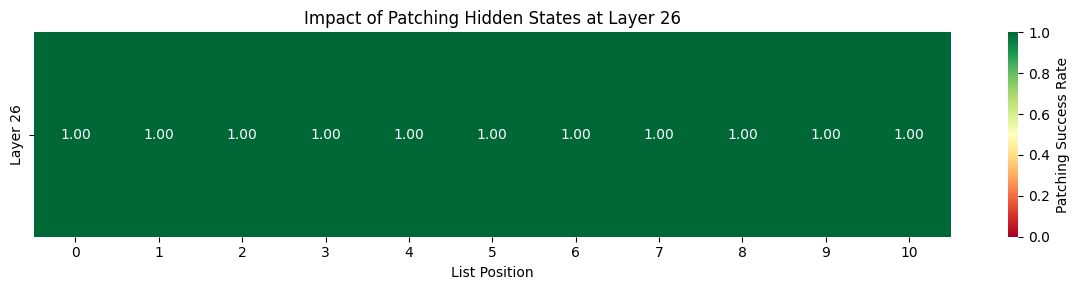


Patching at layer 27...


  0%|                                                            | 0/100 [00:00<?, ?it/s]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġbear', ',', 'Ġlion', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'bear', 'lion', 'sheep', 'tangerine', 'peach']
  Found positions: [31, 34, 36, 38, 40, 44]
  Valid positions: [31, 34, 36, 38, 40, 44]


/tmp/ipykernel_1259488/1956784609.py:186: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision to save memory
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 75%|██████████████████████████████████████▎            | 75/100 [01:46<00:43


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġvehicle', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpear', ',', 'Ġplane', ',', 'Ġpeach', ',']
  Looking for items: ['stool', 'pear', 'plane', 'peach', 'chair', 'dresser', 'scooter']
  Found positions: [31, 34, 36, 38, 40, 42, 44]
  Valid positions: [31, 34, 36, 38, 40, 42, 44]


 82%|█████████████████████████████████████████▊         | 82/100 [01:55<00:25,  1.44s/it]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpiano', ',', 'Ġorange', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'piano', 'orange', 'sheep', 'clarinet', 'truck', 'dresser', 'chair', 'horse', 'harp']
  Found positions: [31, 34, 36, 38, 40, 43, 45, 47, 49, -1]
  Valid positions: [31, 34, 36, 38, 40, 43, 45, 47, 49]


100%|██████████████████████████████████████████████████| 100/100 [02:17<00:00,  1.38s/it]


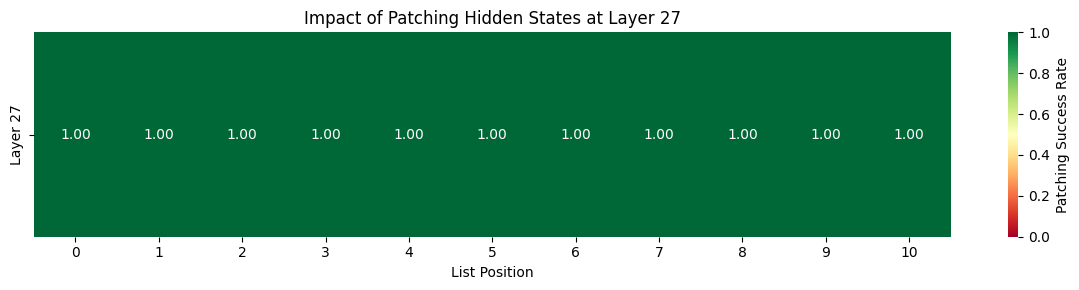


Patching at layer 28...


  0%|                                                            | 0/100 [00:00<?, ?it/s]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġbear', ',', 'Ġlion', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'bear', 'lion', 'sheep', 'tangerine', 'peach']
  Found positions: [31, 34, 36, 38, 40, 44]
  Valid positions: [31, 34, 36, 38, 40, 44]


/tmp/ipykernel_1259488/1956784609.py:186: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision to save memory
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 75%|██████████████████████████████████████▎            | 75/100 [01:43<00:41


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġvehicle', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpear', ',', 'Ġplane', ',', 'Ġpeach', ',']
  Looking for items: ['stool', 'pear', 'plane', 'peach', 'chair', 'dresser', 'scooter']
  Found positions: [31, 34, 36, 38, 40, 42, 44]
  Valid positions: [31, 34, 36, 38, 40, 42, 44]


 82%|█████████████████████████████████████████▊         | 82/100 [01:53<00:24,  1.36s/it]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpiano', ',', 'Ġorange', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'piano', 'orange', 'sheep', 'clarinet', 'truck', 'dresser', 'chair', 'horse', 'harp']
  Found positions: [31, 34, 36, 38, 40, 43, 45, 47, 49, -1]
  Valid positions: [31, 34, 36, 38, 40, 43, 45, 47, 49]


100%|██████████████████████████████████████████████████| 100/100 [02:19<00:00,  1.40s/it]


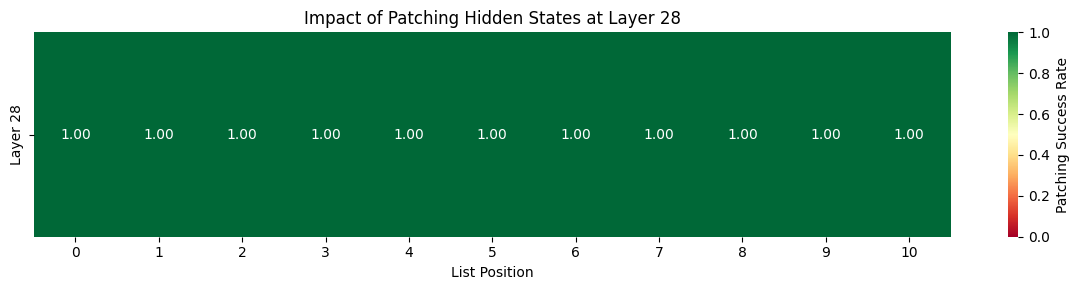


Patching at layer 29...


  0%|                                                            | 0/100 [00:00<?, ?it/s]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġbear', ',', 'Ġlion', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'bear', 'lion', 'sheep', 'tangerine', 'peach']
  Found positions: [31, 34, 36, 38, 40, 44]
  Valid positions: [31, 34, 36, 38, 40, 44]


/tmp/ipykernel_1259488/1956784609.py:186: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision to save memory
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 75%|██████████████████████████████████████▎            | 75/100 [01:45<00:38


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġvehicle', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpear', ',', 'Ġplane', ',', 'Ġpeach', ',']
  Looking for items: ['stool', 'pear', 'plane', 'peach', 'chair', 'dresser', 'scooter']
  Found positions: [31, 34, 36, 38, 40, 42, 44]
  Valid positions: [31, 34, 36, 38, 40, 42, 44]


 82%|█████████████████████████████████████████▊         | 82/100 [01:53<00:20,  1.12s/it]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpiano', ',', 'Ġorange', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'piano', 'orange', 'sheep', 'clarinet', 'truck', 'dresser', 'chair', 'horse', 'harp']
  Found positions: [31, 34, 36, 38, 40, 43, 45, 47, 49, -1]
  Valid positions: [31, 34, 36, 38, 40, 43, 45, 47, 49]


100%|██████████████████████████████████████████████████| 100/100 [02:19<00:00,  1.40s/it]


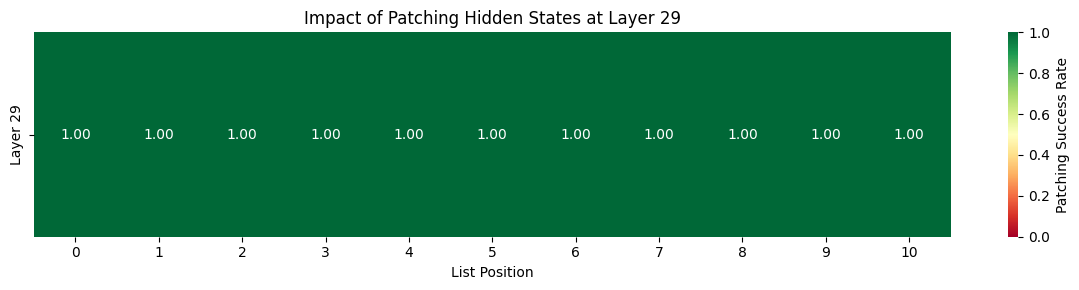


Patching at layer 30...


  0%|                                                            | 0/100 [00:00<?, ?it/s]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġbear', ',', 'Ġlion', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'bear', 'lion', 'sheep', 'tangerine', 'peach']
  Found positions: [31, 34, 36, 38, 40, 44]
  Valid positions: [31, 34, 36, 38, 40, 44]


/tmp/ipykernel_1259488/1956784609.py:186: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision to save memory
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 75%|██████████████████████████████████████▎            | 75/100 [01:51<00:38


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġvehicle', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpear', ',', 'Ġplane', ',', 'Ġpeach', ',']
  Looking for items: ['stool', 'pear', 'plane', 'peach', 'chair', 'dresser', 'scooter']
  Found positions: [31, 34, 36, 38, 40, 42, 44]
  Valid positions: [31, 34, 36, 38, 40, 42, 44]


 82%|█████████████████████████████████████████▊         | 82/100 [01:59<00:21,  1.19s/it]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpiano', ',', 'Ġorange', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'piano', 'orange', 'sheep', 'clarinet', 'truck', 'dresser', 'chair', 'horse', 'harp']
  Found positions: [31, 34, 36, 38, 40, 43, 45, 47, 49, -1]
  Valid positions: [31, 34, 36, 38, 40, 43, 45, 47, 49]


100%|██████████████████████████████████████████████████| 100/100 [02:24<00:00,  1.44s/it]


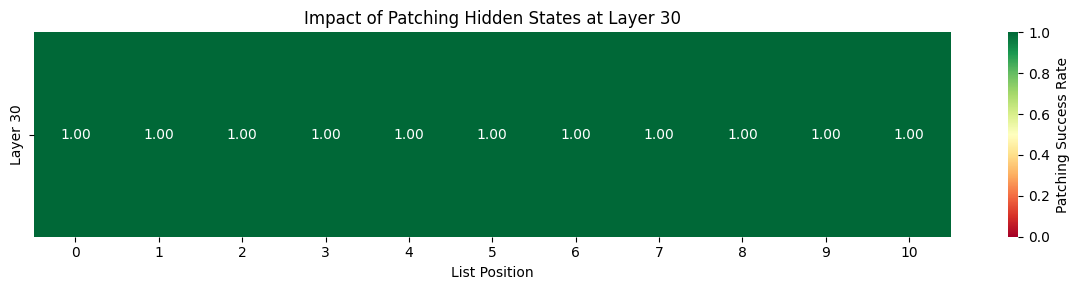


Patching at layer 31...


  0%|                                                            | 0/100 [00:00<?, ?it/s]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġbear', ',', 'Ġlion', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'bear', 'lion', 'sheep', 'tangerine', 'peach']
  Found positions: [31, 34, 36, 38, 40, 44]
  Valid positions: [31, 34, 36, 38, 40, 44]


/tmp/ipykernel_1259488/1956784609.py:186: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use mixed precision to save memory
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/net/scratch/slhleosun/miniconda3/envs/fixed_ai_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
 75%|██████████████████████████████████████▎            | 75/100 [01:45<00:40


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġvehicle', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpear', ',', 'Ġplane', ',', 'Ġpeach', ',']
  Looking for items: ['stool', 'pear', 'plane', 'peach', 'chair', 'dresser', 'scooter']
  Found positions: [31, 34, 36, 38, 40, 42, 44]
  Valid positions: [31, 34, 36, 38, 40, 42, 44]


 82%|█████████████████████████████████████████▊         | 82/100 [01:54<00:25,  1.44s/it]


Debug - Tokenization:
  Tokens (first 40): ['<|begin_of_text|>', 'Count', 'Ġthe', 'Ġnumber', 'Ġof', 'Ġwords', 'Ġin', 'Ġthe', 'Ġfollowing', 'Ġlist', 'Ġthat', 'Ġmatch', 'Ġthe', 'Ġgiven', 'Ġtype', ',', 'Ġand', 'Ġput', 'Ġthe', 'Ġnumerical', 'Ġanswer', 'Ġin', 'Ġparentheses', '.Ċ', 'Type', ':', 'Ġfruit', 'Ċ', 'List', ':', 'Ġ[', 'st', 'ool', ',', 'Ġpiano', ',', 'Ġorange', ',', 'Ġsheep', ',']
  Looking for items: ['stool', 'piano', 'orange', 'sheep', 'clarinet', 'truck', 'dresser', 'chair', 'horse', 'harp']
  Found positions: [31, 34, 36, 38, 40, 43, 45, 47, 49, -1]
  Valid positions: [31, 34, 36, 38, 40, 43, 45, 47, 49]


100%|██████████████████████████████████████████████████| 100/100 [02:19<00:00,  1.39s/it]


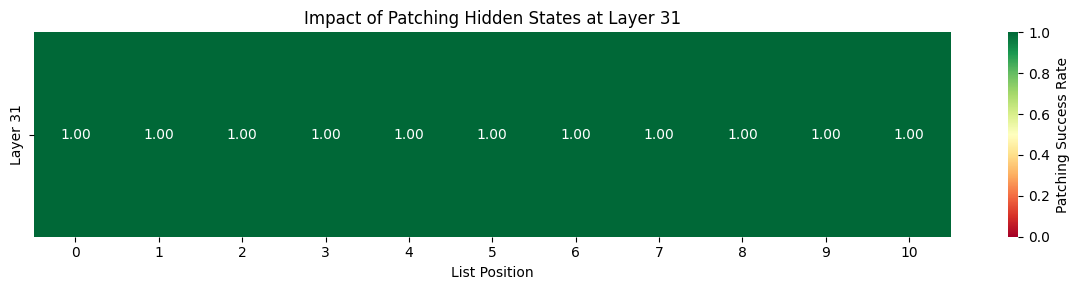


Creating final visualizations...


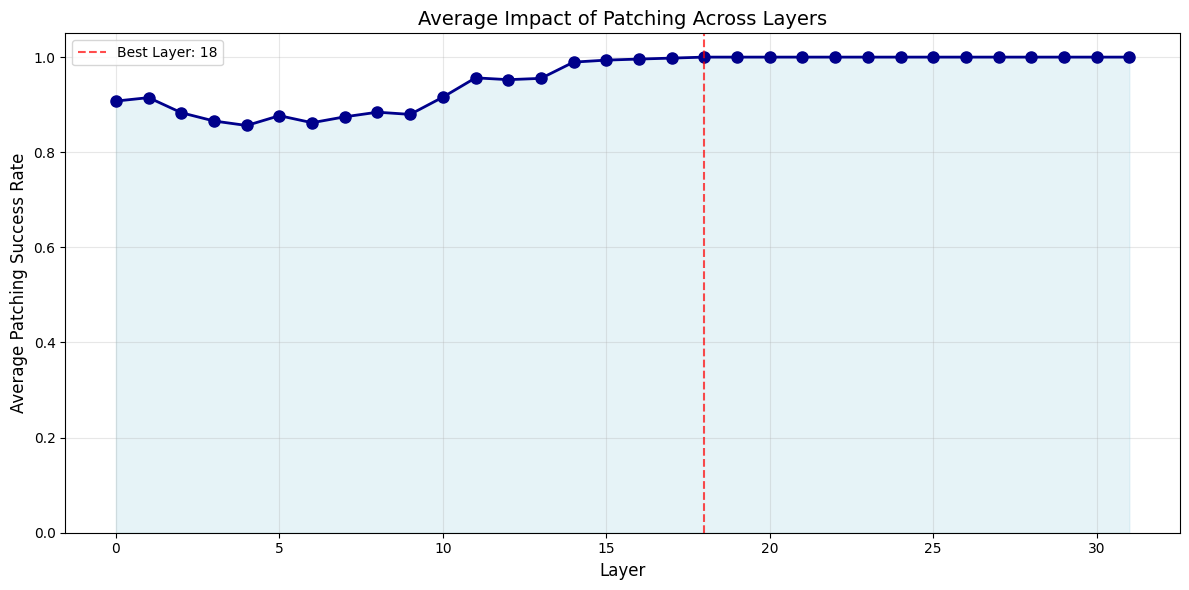


Analysis complete! Results saved to patching_results.json and plots in interp_plots/


In [5]:
def main():
    # Set CUDA environment for better debugging
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
    
    # Step 1: Extract correct predictions
    input_file = "/net/scratch/slhleosun/counting-items-mechanisms/behavioral_results/llama3-8b-inst/predictions.jsonl"
    output_file = "correct_predictions.jsonl"
    correct_prompts = extract_correct_predictions(input_file, output_file)
    
    # Step 2 & 3: Run clean and counterfactual runs, collect hidden states
    print("\nCollecting hidden states for clean runs...")
    clean_hidden_states = {}
    running_counts_all = {}
    token_positions_all = {}
    
    # Also collect some statistics
    total_items = 0
    total_matches = 0
    
    # Process in smaller batches to avoid memory issues
    batch_size = 5
    num_samples = 100  
    
    for batch_start in range(0, min(num_samples, len(correct_prompts)), batch_size):
        batch_end = min(batch_start + batch_size, num_samples, len(correct_prompts))
        print(f"\nProcessing batch {batch_start//batch_size + 1}/{(num_samples + batch_size - 1)//batch_size}")
        
        for idx in tqdm(range(batch_start, batch_end)):
            prompt_data = correct_prompts[idx]
            prompt = prompt_data['prompt']
            
            try:
                category, items = parse_prompt(prompt)
                
                # Get token positions for list items
                token_positions = get_token_positions_for_items(tokenizer, prompt, items)
                
                # Skip if we couldn't find enough token positions
                if len(token_positions) < len(items) * 0.5:  # If we found less than half
                    print(f"\nWarning: Could only find {len(token_positions)}/{len(items)} items in prompt {idx}")
                    continue
                    
                token_positions_all[idx] = token_positions
                
                # Tokenize
                inputs = tokenizer(prompt, return_tensors="pt", padding=True).to(device)
                
                # Get hidden states
                hidden_states = get_hidden_states_with_hook(model, inputs.input_ids)
                
                # Store hidden states for each layer
                for layer_idx in range(num_layers):
                    if layer_idx not in clean_hidden_states:
                        clean_hidden_states[layer_idx] = {}
                    clean_hidden_states[layer_idx][idx] = hidden_states[f"layer_{layer_idx}"]
                
                # Compute cumulative counts at each token position
                running_counts = get_cumulative_counts_up_to_position(items, category, token_positions)
                running_counts_all[idx] = running_counts
                
                # Collect statistics
                total_items += len(items)
                final_count = count_category_matches(items, category)
                total_matches += final_count
                
                # Debug first few examples
                if idx < 3:
                    print(f"\nDebug - Example {idx}:")
                    print(f"  Category: {category}")
                    print(f"  Items: {items}")
                    print(f"  Gold answer: {prompt_data['gold']}")
                    print(f"  Actual count: {final_count}")
                    print(f"  Token positions found: {len(token_positions)}/{len(items)}")
                    print(f"  Running counts: {running_counts}")
                
                # Clean up
                del inputs
                del hidden_states
                
            except Exception as e:
                print(f"Error processing prompt {idx}: {e}")
                continue
        
        # Clear GPU memory after each batch
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.synchronize()
            torch.cuda.empty_cache()
    
    print(f"\nDataset statistics:")
    print(f"  Total items: {total_items}")
    print(f"  Total matches: {total_matches}")
    print(f"  Match rate: {total_matches/total_items:.2%}" if total_items > 0 else "N/A")
    
    # Step 4: Train probes at each layer
    print("\nTraining probes at each layer...")
    probe_scores = {}
    probes = {}
    
    for layer_idx in tqdm(range(num_layers)):
        if layer_idx in clean_hidden_states and clean_hidden_states[layer_idx]:
            probe, score = train_probes(clean_hidden_states[layer_idx], running_counts_all, token_positions_all, layer_idx)
            probe_scores[layer_idx] = score
            probes[layer_idx] = probe
            print(f"Layer {layer_idx}: R² score = {score:.4f}")
        else:
            probe_scores[layer_idx] = 0.0
            probes[layer_idx] = None
    
    # Find best layer
    if probe_scores:
        best_layer = max(probe_scores, key=probe_scores.get)
        print(f"\nBest layer for count tracking: Layer {best_layer} (R² = {probe_scores[best_layer]:.4f})")
        
        # Visualize probe scores
        visualize_probe_scores(probe_scores, best_layer)
    else:
        print("Error: No probe scores computed")
        return
    
    # Step 5 & 6: Patch and evaluate on multiple layers
    print("\nPatching and evaluating...")
    
    # Select layers to evaluate - best layer + evenly spaced others
    layers_to_evaluate = [best_layer]  # Start with best layer
    other_layers = [i for i in range(0, num_layers) if i != best_layer]  
    layers_to_evaluate.extend(other_layers)
    layers_to_evaluate = sorted(set(layers_to_evaluate))  # Remove duplicates and sort
    
    print(f"Evaluating layers: {layers_to_evaluate}")
    
    all_layer_results = {}
    num_prompts_to_patch = min(100, len(correct_prompts)) 
    
    for layer_idx in layers_to_evaluate:
        print(f"\nPatching at layer {layer_idx}...")
        layer_patching_results = []
        
        for prompt_data in tqdm(correct_prompts[:num_prompts_to_patch]):
            try:
                results = patch_and_evaluate(model, tokenizer, prompt_data, layer_idx, probes)
                layer_patching_results.extend(results)
            except Exception as e:
                print(f"Error patching prompt: {e}")
                continue
        
        all_layer_results[layer_idx] = layer_patching_results
        
        # Visualize results for this layer
        if layer_patching_results:
            visualize_patching_heatmap(layer_patching_results, layer_idx)
        
        # Clear memory
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.synchronize()
            torch.cuda.empty_cache()
    
    # Step 7: Final visualization - averaged impact across layers
    print("\nCreating final visualizations...")
    visualize_averaged_impact(all_layer_results)
    
    # Save detailed results
    with open('patching_results.json', 'w') as f:
        json.dump({
            'probe_scores': probe_scores,
            'best_layer': best_layer,
            'layers_evaluated': layers_to_evaluate,
            'patching_results_by_layer': {str(k): v for k, v in all_layer_results.items()},
            'dataset_stats': {
                'total_items': total_items,
                'total_matches': total_matches,
                'match_rate': total_matches/total_items if total_items > 0 else 0
            }
        }, f, indent=2)
    
    print("\nAnalysis complete! Results saved to patching_results.json and plots in interp_plots/")

if __name__ == "__main__":
    main()